# Dataframe exploration

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import missingno as msno
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [2]:
df = pd.read_csv(r"data_files\steam_charts_final.csv", parse_dates=["month","release_date"])


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51942 entries, 0 to 51941
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      51942 non-null  datetime64[ns]
 1   average_players            51942 non-null  float64       
 2   peak_players               51942 non-null  int64         
 3   app_id                     51942 non-null  int64         
 4   game                       51942 non-null  object        
 5   player_gain                51942 non-null  float64       
 6   player_gain_percentage     51942 non-null  float64       
 7   short_description          47466 non-null  object        
 8   required_age               51942 non-null  float64       
 9   dlc                        29870 non-null  object        
 10  supported_languages        47466 non-null  object        
 11  developers                 47466 non-null  object        
 12  publ

### Correlations

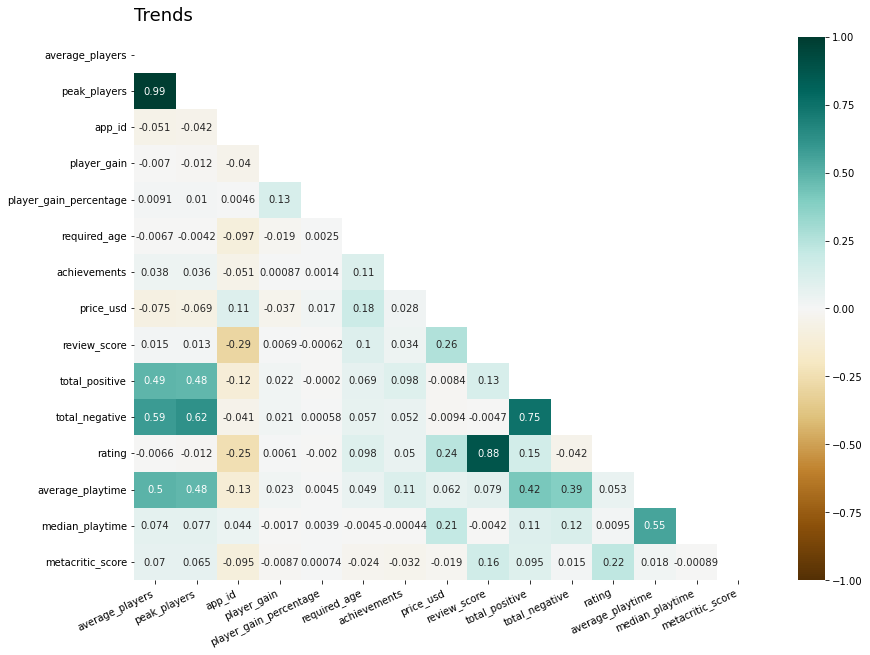

In [4]:
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title("Trends", fontdict={'fontsize':18}, pad=16, loc = "left")
plt.xticks(rotation = 25, ha = "right")
plt.show()

### Correlations

Notable correlations:

- peak_players - average_players 0.99
- total_positive - average_players 0.49
- total_negative - average_players 0.59
- average_playtime - average_players 0.5
-----------------------------------------

- total_positive - peak_players 0.48
- total_negative - peak_players 0.62
- average_playtime - peak_players 0.48
------------------------------------

- review_score - price_usd 0.26
- rating - price_usd 0.24

Not too surprisingly, "peak_players" and "average_players" are strongly correlated. "peak_players" is the highest recorded number of players at one point during the month. "average_players" is the calculated average over the month; this means that the total player count was recorded each day and then divided by the number of days in a month. 

You'll notice that there are moderate correlations between "total_positive", "total_negative" and "peak_players"/"average_players". This suggests that as the number of people playing a game increases, the greater number of reviews are created.




### Data review

Even though **most** of the missing data has been dealt with, lets review the missing data in all of the columns. I probably won't worry about replacing any missing values for the columns that have missing data points. Most of these columns are categorical, thus are more difficult to fix. Two of the columns "tags" and "categories" are lists containing individual elements, which makes analysis on these more difficult and less straight-forward.

In [5]:
# Percent of missing data, sorted descending order
(df.apply(pd.isnull).sum()/df.shape[0] * 100).sort_values(ascending=False)

metacritic_url              50.09
dlc                         42.49
supported_audio             41.46
is_recurring_subscription   23.02
tags                         9.38
genres                       9.06
supported_languages          8.62
developers                   8.62
publishers                   8.62
platforms                    8.62
categories                   8.62
short_description            8.62
player_gain_percentage       0.00
total_negative               0.00
peak_players                 0.00
metacritic_score             0.00
app_id                       0.00
median_playtime              0.00
average_playtime             0.00
total_owners_estimated       0.00
rating                       0.00
game                         0.00
total_positive               0.00
review_score                 0.00
price_usd                    0.00
release_date                 0.00
achievements                 0.00
average_players              0.00
player_gain                  0.00
required_age  

### Unique values

I mentioned above that two columns contain are lists. "tags" and "categories" have multiple elements inside a list. Similar to other forms of media/entertainment, video games have different categories/tags they belong to. We'll see below that a game could belong to "Single-Player" and "Multiplayer", which would indicate there are multiple modes. Games could also be considered "action" and "adventure", or "RPG" and "Strategy", and many different combinations.

To accurately count these list elements and visualize this information, this data needs to be condensed down to the unique values. The current data has multiple rows of the same game. Each game has records for every different month and the associated player trend.

This means that each game should only be one row, and the final length of this dataset should be less than 1,000 rows. To accomplish this task, we can use `.drop_duplicates` method to drop duplicate values in the "game" column. 

In [6]:
# Drop duplicates based on the game column
# Re-assign as a copy to a new variable
unique_games = df.drop_duplicates(subset="game").copy()

In [7]:
# Verify the number of rows
print(unique_games.shape)

# Verify the total unique values in the game column
print(unique_games["game"].nunique())

(979, 31)
979


In [8]:
# Fill in missing values with "n/a" to avoid any errors
unique_games["tags"] = unique_games["tags"].fillna("n/a")

# Split the list elements on the comma
unique_games["tags"] = unique_games["tags"].str.split(",")

In [9]:
# Preview
unique_games[["game","tags"]]

,game,tags
0,Counter-Strike: Global Offensive,"[['FPS', 'Shooter', 'Multiplayer', 'Competi..."
120,Dota 2,"[['Free to Play', 'MOBA', 'Multiplayer', 'S..."
240,Lost Ark,[n/a]
245,PUBG: BATTLEGROUNDS,"[['Survival', 'Shooter', 'Multiplayer', 'Ba..."
309,Apex Legends,"[['Free to Play', 'Battle Royale', 'Multipla..."
...,...,...
51648,Trainz Railroad Simulator 2019,"[['Simulation', 'Trains', 'Driving', 'Open ..."
51690,Eternium,[n/a]
51699,Command and Conquer: Red Alert 3 - Uprising,"[['Strategy', 'RTS', 'Base-Building', 'Sing..."
51819,Metro: Last Light Redux,"[['Post-apocalyptic', 'FPS', 'Atmospheric', ..."


In [10]:
#tags = list()

If we count the elements of the "tags" and "categories" columns it should help to understand the data. Generally, single player and multiplayer tags are the most numerous. This does not mean they are the most "popular" or highest reviewed, or most trending, etc... A count of these tags and categories helps us to undestand what we'll typically see in the data. 

Using a for loop I can count each individual list element from every row. Within the for loop a list element will be added to a dictionary as the key if it does not currently exist. If it already does exist, the count will be incremented by one. The end of this loop will produce an accurate count of each tag and category.

The same process will be implemented for the "tags" column and the "category". 

Dictionaries can be converted to pandas dataframes with the function `pd.DataFrame.from_dict()`. As a dataframe, every individual tag/category will be a single row with the associated count as a seperate column. This makes it easier to visualize as a chart.

In [11]:
# Initialize an empty dictionary to store each tag
tag_count = {}

# Utilize a for loop to iterate through each row
for tag in unique_games["tags"]:    # each tag is the list of every row
    for tag_item in tag:            # tag_item is the individual element of the list
        if tag_item in tag_count:   # if the tag_item is in the dictionary "tag_count"
            tag_count[tag_item] +=1 # increment the count by 1
        else:
            tag_count[tag_item] = 1 # if the tag_item is not in the dictionary, then add to dict and add 1


In [12]:
# Preview the dictionary
tag_count

{"['FPS'": 23,
 " 'Shooter'": 176,
 " 'Multiplayer'": 510,
 " 'Competitive'": 49,
 " 'Action'": 468,
 " 'Team-Based'": 62,
 " 'e-sports'": 25,
 " 'Tactical'": 123,
 " 'First-Person'": 229,
 " 'PvP'": 167,
 " 'Online Co-Op'": 208,
 " 'Co-op'": 327,
 " 'Strategy'": 266,
 " 'Military'": 80,
 " 'War'": 121,
 " 'Difficult'": 126,
 " 'Trading'": 11,
 " 'Realistic'": 129,
 " 'Fast-Paced'": 14,
 " 'Moddable']": 9,
 "['Free to Play'": 82,
 " 'MOBA'": 8,
 " 'RTS'": 78,
 " 'Tower Defense'": 19,
 " 'Fantasy'": 157,
 " 'RPG'": 238,
 " 'Character Customization'": 126,
 " 'Replay Value'": 74,
 " 'Action RPG'": 80,
 " 'Simulation']": 12,
 'n/a': 156,
 "['Survival'": 21,
 " 'Battle Royale'": 11,
 " 'FPS'": 125,
 " 'Third-Person Shooter'": 52,
 " 'Early Access'": 128,
 " 'Third Person'": 183,
 " 'Simulation'": 263,
 " 'Stealth']": 4,
 " 'Hero Shooter'": 9,
 " 'Survival'": 173,
 " 'Sci-fi'": 125,
 " 'Funny'": 139,
 " 'Loot'": 31,
 " 'Lore-Rich'": 19,
 " 'Cyberpunk'": 9,
 " 'Cinematic']": 3,
 "['Open Worl

In [13]:
# Transforms dictionary to dataframe 
tag_count = pd.DataFrame.from_dict(tag_count, orient="index", columns= ["Count"])

# Reset index
tag_count = tag_count.reset_index(level = 0)

# Rename the index to "Tags"
tag_count = tag_count.rename(columns = {"index":"Tags"})

In [14]:
# Dataframe will need some string cleanup to remove quotation marks and brackets
tag_count.sort_values(by="Count",ascending=False)

,Tags,Count
56,'Singleplayer',603
2,'Multiplayer',510
4,'Action',468
52,'Adventure',392
11,'Co-op',327
...,...,...
557,'Pinball',1
565,'Diplomacy'],1
568,['Cute',1
569,['Bullet Hell',1


In [15]:
#
tag_count["Tags"] = tag_count["Tags"]\
                        .str.replace("'","")\
                        .str.replace("[","",regex=True)\
                        .str.replace("]","",regex=True)\
                        .str.strip()

In [16]:
tag_count["Tags"].unique()

array(['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action',
       'Team-Based', 'e-sports', 'Tactical', 'First-Person', 'PvP',
       'Online Co-Op', 'Co-op', 'Strategy', 'Military', 'War',
       'Difficult', 'Trading', 'Realistic', 'Fast-Paced', 'Moddable',
       'Free to Play', 'MOBA', 'RTS', 'Tower Defense', 'Fantasy', 'RPG',
       'Character Customization', 'Replay Value', 'Action RPG',
       'Simulation', 'n/a', 'Survival', 'Battle Royale',
       'Third-Person Shooter', 'Early Access', 'Third Person', 'Stealth',
       'Hero Shooter', 'Sci-fi', 'Funny', 'Loot', 'Lore-Rich',
       'Cyberpunk', 'Cinematic', 'Open World Survival Craft',
       'Open World', 'Dinosaurs', 'Crafting', 'Building', 'Adventure',
       'Base-Building', 'Sandbox', 'Massively Multiplayer',
       'Singleplayer', 'Dragons', 'Indie', 'Automobile Sim', 'Crime',
       'Mature', 'Racing', 'Atmospheric', 'Great Soundtrack', 'Comedy',
       'Class-Based', 'Cartoony', 'Robots', 'Cartoon', 'Nudity',
   

<AxesSubplot:xlabel='Count', ylabel='Tags'>

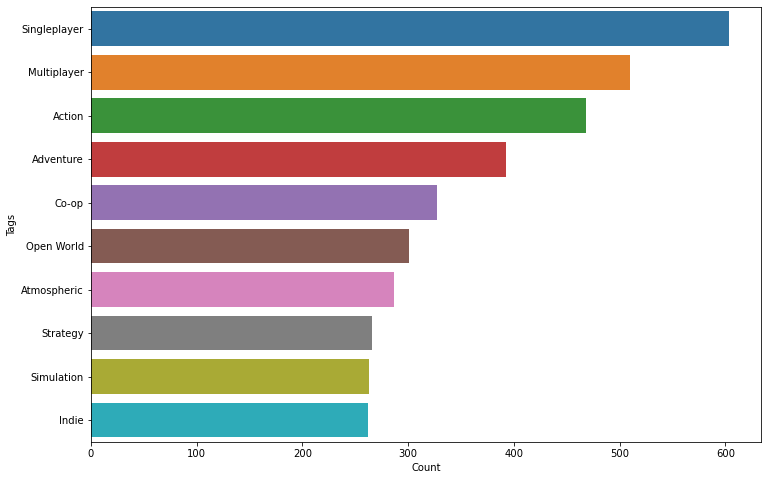

In [17]:
plt.figure(figsize=(12,8))
sns.barplot(x = "Count", y = "Tags", data = tag_count.nlargest(10, "Count"), orient = "h")

<AxesSubplot:xlabel='Count', ylabel='Tags'>

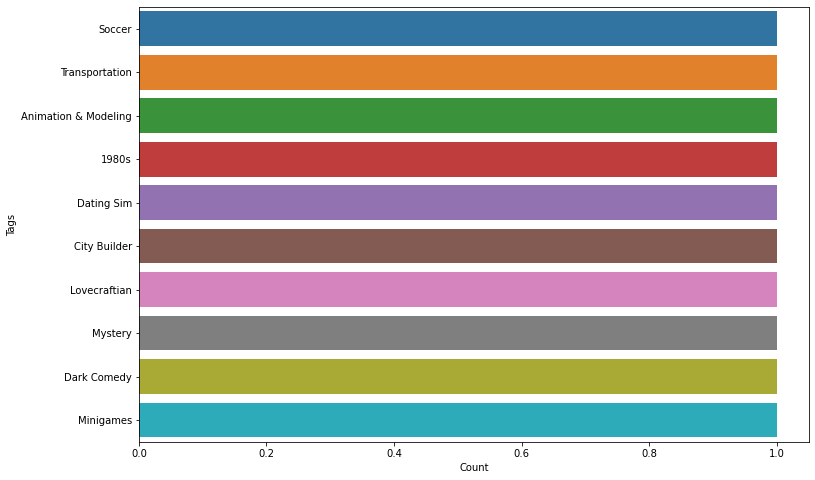

In [18]:
plt.figure(figsize=(12,8))
sns.barplot(x = "Count", y = "Tags", data = tag_count.nsmallest(10, "Count"), orient = "h")

### Game tags or "genres/categories"

One game may have multiple tags.
Singleplayer and multiplayer are the two most common tags. However, these two tags by themselves are vague. Singleplayer could represent thousands of different games.

**count the most common pairs**?

In [19]:
games_count = df["game"].value_counts().sort_values(ascending=False)

- value of 120 / 12 months = 10 years
- dataset goes back to 2012
- 79 games that date back to 2012

In [20]:
len(games_count[games_count.values == 120])

78

In [21]:
older_games = games_count[games_count.values == 120]

In [22]:
older_games.index.tolist()

['Counter-Strike: Global Offensive',
 'Dota 2',
 'Age of Empires® III (2007)',
 'Spore',
 'Warhammer 40,000: Dawn of War - Soulstorm',
 'Rome: Total War',
 'Dragon Age: Origins - Ultimate Edition',
 'Source Filmmaker',
 'Grand Theft Auto IV: The Complete Edition',
 'The Lord of the Rings Online™',
 'Total War: SHOGUN 2',
 'Stronghold Crusader HD',
 "Assassin's Creed II",
 'The Elder Scrolls IV: Oblivion',
 'Star Trek Online',
 'Realm of the Mad God Exalt',
 'The Sims™ 3',
 'Portal 2',
 'Resident Evil 5',
 'Half-Life 2',
 'Victoria II',
 "Garry's Mod",
 'Warhammer 40,000: Dawn of War - Dark Crusade',
 'Day of Defeat: Source',
 'Bejeweled 3',
 'Command and Conquer: Red Alert 3 - Uprising',
 "Assassin's Creed Brotherhood",
 'Terraria',
 'Football Manager 2012',
 "Sid Meier's Civilization V",
 'Grand Theft Auto: San Andreas',
 'Left 4 Dead 2',
 'Team Fortress 2',
 'Total War: NAPOLEON - Definitive Edition',
 'DC Universe Online',
 'Fallout: New Vegas PCR',
 'Crusader Kings II',
 'The Witch

In [23]:
unique_games[["game","categories"]]

,game,categories
0,Counter-Strike: Global Offensive,"['Multi-player', 'Steam Achievements', 'Full c..."
120,Dota 2,"['Multi-player', 'Co-op', 'Steam Trading Cards..."
240,Lost Ark,NaN
245,PUBG: BATTLEGROUNDS,"['Multi-player', 'PvP', 'Online PvP', 'Stats',..."
309,Apex Legends,"['Multi-player', 'PvP', 'Online PvP', 'Co-op',..."
...,...,...
51648,Trainz Railroad Simulator 2019,"['Single-player', 'Multi-player', 'Co-op', 'St..."
51690,Eternium,"['Single-player', 'In-App Purchases']"
51699,Command and Conquer: Red Alert 3 - Uprising,['Single-player']
51819,Metro: Last Light Redux,"['Single-player', 'Steam Achievements', 'Full ..."


In [24]:
unique_games["categories"] = unique_games["categories"].fillna("n/a")
unique_games["categories"] = unique_games["categories"].str.split(",")

In [25]:
unique_games["categories"]

0        [['Multi-player',  'Steam Achievements',  'Ful...
120      [['Multi-player',  'Co-op',  'Steam Trading Ca...
240                                                  [n/a]
245      [['Multi-player',  'PvP',  'Online PvP',  'Sta...
309      [['Multi-player',  'PvP',  'Online PvP',  'Co-...
                               ...                        
51648    [['Single-player',  'Multi-player',  'Co-op', ...
51690             [['Single-player',  'In-App Purchases']]
51699                                  [['Single-player']]
51819    [['Single-player',  'Steam Achievements',  'Fu...
51913    [['Single-player',  'Captions available',  'Re...
Name: categories, Length: 979, dtype: object

In [26]:
category_count = dict()

for category in unique_games["categories"]:
    for item in category:
        if item in category_count:
            category_count[item] +=1
        else:
            category_count[item] = 1

category_count

{"['Multi-player'": 137,
 " 'Steam Achievements'": 608,
 " 'Full controller support'": 297,
 " 'Steam Trading Cards'": 403,
 " 'Steam Workshop'": 163,
 " 'In-App Purchases'": 113,
 " 'Valve Anti-Cheat enabled'": 23,
 " 'Stats'": 53,
 " 'Remote Play on Phone'": 159,
 " 'Remote Play on Tablet'": 128,
 " 'Remote Play on TV']": 108,
 " 'Co-op'": 350,
 " 'SteamVR Collectibles'": 2,
 " 'Valve Anti-Cheat enabled']": 14,
 'n/a': 100,
 " 'PvP'": 336,
 " 'Online PvP'": 323,
 " 'Remote Play on Tablet']": 130,
 " 'Online Co-op'": 282,
 " 'In-App Purchases']": 84,
 "['Single-player'": 716,
 " 'Multi-player'": 416,
 " 'MMO'": 86,
 " 'Steam Cloud'": 301,
 " 'Includes level editor'": 42,
 " 'Cross-Platform Multiplayer'": 125,
 " 'Captions available'": 39,
 " 'Partial Controller Support'": 127,
 " 'Commentary available'": 9,
 " 'Partial Controller Support']": 53,
 " 'Steam Cloud']": 169,
 " 'Shared/Split Screen PvP'": 55,
 " 'Shared/Split Screen Co-op'": 61,
 " 'Shared/Split Screen'": 82,
 " 'Steam Tra

In [27]:
# Transforms dictionary to dataframe 
category_count = pd.DataFrame.from_dict(category_count, orient="index", columns= ["Count"])
category_count = category_count.reset_index(level = 0)
category_count = category_count.rename(columns = {"index":"Categories"})

In [28]:
category_count["Categories"] = category_count["Categories"]\
                                                            .str.replace("'","")\
                                                            .str.replace("[","",regex=True)\
                                                            .str.replace("]","",regex=True)

<AxesSubplot:xlabel='Count', ylabel='Categories'>

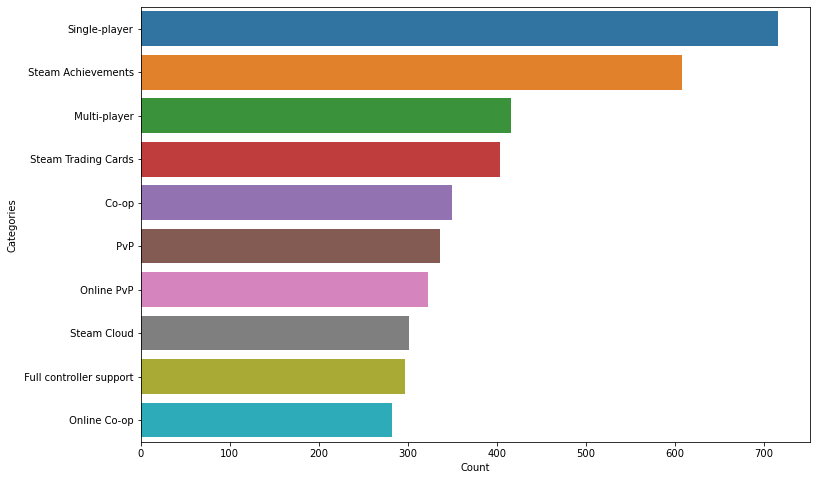

In [29]:
plt.figure(figsize=(12,8))
sns.barplot(x = "Count", y = "Categories", data = category_count.nlargest(10, "Count"), orient = "h")

In [30]:
df.head()

,month,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription
0,2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
1,2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
2,2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
3,2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
4,2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51942 entries, 0 to 51941
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      51942 non-null  datetime64[ns]
 1   average_players            51942 non-null  float64       
 2   peak_players               51942 non-null  int64         
 3   app_id                     51942 non-null  int64         
 4   game                       51942 non-null  object        
 5   player_gain                51942 non-null  float64       
 6   player_gain_percentage     51942 non-null  float64       
 7   short_description          47466 non-null  object        
 8   required_age               51942 non-null  float64       
 9   dlc                        29870 non-null  object        
 10  supported_languages        47466 non-null  object        
 11  developers                 47466 non-null  object        
 12  publ

In [32]:
df

,month,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription
0,2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
1,2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
2,2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
3,2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
4,2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51937,2020-06-30,444.60,1019,625960,Stoneshard,-37.79,-7.83,Stoneshard is a challenging turn-based RPG set...,0.00,True,"['English', 'French', 'German', 'Italian', 'Ja...",['Ink Stains Games'],['HypeTrain Digital'],"['windows', 'linux']","['Single-player', 'Captions available', 'Remot...","['Adventure', 'Indie', 'RPG', 'Strategy', 'Ear...",54.00,2020-02-06,NaN,26.71,6.00,15281.00,4705.00,75.12,500000-1000000,1338.00,769.00,"['RPG', 'Strategy', 'Rogue-like', 'Open World ...",81.23,NaN,False
51938,2020-05-31,482.40,1400,625960,Stoneshard,-605.05,-55.64,Stoneshard is a challenging turn-bas

### Extract the year and month name
Extract individual year and month for groupby operations.

In [33]:
df["year"] = df["month"].dt.year
df["month_name"] = df["month"].dt.month_name()

### Differences between average and median

Steam has over 60,000 titles currently listed on the store page. The likely large discrepency between the average and median values is due to a smaller portion of steam games being popular.
Nearly anyone can develop a game and publish it to steam, whereas there are far fewer professional developers. What is probably happening is most people are attracted to a far smaller selection of higher quality titles compared to most of the games published.

In [34]:
df.describe()

,average_players,peak_players,app_id,player_gain,player_gain_percentage,required_age,achievements,price_usd,review_score,total_positive,total_negative,rating,average_playtime,median_playtime,metacritic_score,year
count,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00
mean,5803.58,11219.46,438313.71,-133.26,inf,2.47,63.42,20.70,7.35,49776.64,6228.47,82.61,2925.67,1058.94,81.23,2018.69
std,36838.04,68895.73,364967.25,6273.96,NaN,6.07,119.40,15.86,1.87,170035.18,35032.29,11.72,4342.96,3150.74,5.46,2.52
min,0.00,0.00,10.00,-310597.48,-100.00,0.00,0.00,0.00,0.00,0.00,0.00,26.97,0.00,0.00,56.00,2012.00
25%,372.12,780.00,221100.00,-133.64,-13.67,0.00,5.00,8.75,7.35,5068.00,628.00,78.84,905.00,286.00,81.23,2017.00
50%,814.93,1708.00,346010.00,-6.88,-1.74,0.00,43.00,20.70,8.00,15987.00,1735.50,85.27,1636.00,566.00,81.23,2019.00
75%,2288.91,4816.00,610370.00,80.81,12.01,0.00,71.00,28.85,8.00,43064.50,4100.00,90.65,3327.00,950.00,82.00,2021.00
max,1584886.77,3236027.00,2011470.00,426446.12,inf,18.00,1354.00,74.81,9.00,2949363.00,733480.00,97.64,41854.00,57446.00,97.00,2022.00


In [35]:
df[df["player_gain_percentage"] == 0].head()

,month,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name
1416,2021-07-31,191.37,410,1418630,Dread Hunger,-0.01,-0.00,A game of survival and betrayal. Eight Explore...,0.00,True,"['English', 'French', 'German', 'Italian', 'Ja...",['Dread Hunger Team'],['Digital Confectioners'],['windows'],"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...","['Action', 'Adventure', 'Indie']",26.00,2022-01-26,['English'],26.71,5.00,16791.00,9662.00,62.85,500000-1000000,3578.00,1519.00,"['Multiplayer', 'Survival', 'Online Co-Op', 'S...",81.23,NaN,False,2021,July
1894,2022-06-30,26371.23,38020,868270,The Cycle: Frontier,0.00,0.00,The Cycle: Frontier is a free-to-play high-sta...,0.00,NaN,"['English', 'French', 'German', 'Italian', 'Ja...",['YAGER'],['YAGER'],['windows'],"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...","['Action', 'Free to Play', 'Massively Multipla...",0.00,2022-01-01,['English'],0.00,0.00,0.00,0.00,50.00,0-20000,0.00,0.00,NaN,81.23,NaN,NaN,2022,June
5046,2022-06-30,10597.80,14484,1824220,Chivalry 2,0.00,0.00,Chivalry 2 is a multiplayer first person slash...,18.00,NaN,"['English', 'French', 'German', 'Italian', 'Ja...",['Torn Banner Studios'],['Tripwire Presents'],['windows'],"['Multi-player', 'PvP', 'Online PvP', 'Cross-P...",['Action'],0.00,2022-06-12,['English'],20.70,0.00,0.00,0.00,50.00,0-20000,0.00,0.00,NaN,82.00,https://www.metacritic.com/game/pc/chivalry-2?...,NaN,2022,June
5948,2022-06-30,6718.75,10778,1462040,FINAL FANTASY VII REMAKE INTERGRADE,0.00,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.00,2022-06-17,NaN,20.70,7.35,15987.00,1735.50,82.61,1000000-2000000,1636.00,566.00,NaN,81.23,NaN,NaN,2022,June
5949,2022-06-30,7996.06,12680,1966900,20 Minutes Till Dawn,0.00,0.00,Shoot down an ever growing horde of Lovecrafti...,0.00,NaN,"['English', 'Japanese', 'Portuguese - Brazil',...",['flanne'],"['flanne', 'Erabit']",['windows'],['Single-player'],['Action'],0.00,2022-06-08,NaN,20.70,0.00,0.00,0.00,50.00,0-20000,0.00,0.00,NaN,81.23,NaN,NaN,2022,June


In [36]:
# For some reason "infinite" values have been generated in the "player_gain_percentage" column
df[df["player_gain_percentage"] == np.inf].head()

,month,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name
1029,2013-06-30,0.08,2,236390,War Thunder,0.08,inf,War Thunder is the most comprehensive free-to-...,0.00,True,"['Czech', 'English', 'French', 'German', 'Hung...",['Gaijin Entertainment'],['Gaijin Distribution KFT'],"['windows', 'mac', 'linux']","['Single-player', 'Multi-player', 'MMO', 'PvP'...","['Action', 'Free to Play', 'Massively Multipla...",53.00,2013-08-15,"[' Russian', 'Czech', 'English', 'French', 'Ge...",0.00,6.00,1236.00,444.00,71.05,20000000-50000000,4696.00,309.00,"['Free to Play', 'Vehicular Combat', 'Combat',...",81.00,https://www.metacritic.com/game/pc/war-thunder...,False,2013,June
1236,2013-02-28,0.00,1,230410,Warframe,0.00,inf,Awaken as an unstoppable warrior and battle al...,18.00,True,"['English', 'French', 'German', 'Italian', 'Ja...",['Digital Extremes'],['Digital Extremes'],['windows'],"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Free to Play', 'RPG']",193.00,2013-03-25,['English'],0.00,8.00,2578.00,324.00,85.31,20000000-50000000,9103.00,354.00,"['Free to Play', 'Action RPG', 'RPG', 'Action'...",69.00,https://www.metacritic.com/game/pc/warframe?ft...,False,2013,February
1237,2013-01-31,0.00,0,230410,Warframe,0.00,inf,Awaken as an unstoppable warrior and battle al...,18.00,True,"['English', 'French', 'German', 'Italian', 'Ja...",['Digital Extremes'],['Digital Extremes'],['windows'],"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Free to Play', 'RPG']",193.00,2013-03-25,['English'],0.00,8.00,2578.00,324.00,85.31,20000000-50000000,9103.00,354.00,"['Free to Play', 'Action RPG', 'RPG', 'Action'...",69.00,https://www.metacritic.com/game/pc/warframe?ft...,False,2013,January
1658,2012-10-31,0.13,3,221100,DayZ,0.13,inf,How long can you survive a post-apocalyptic wo...,18.00,True,"['Czech', 'English', 'French', 'German', 'Ital...",['Bohemia Interactive'],['Bohemia Interactive'],['windows'],"['Multi-player', 'PvP', 'Online PvP', 'Steam W...","['Action', 'Adventure', 'Massively Multiplayer']",0.00,2018-12-13,NaN,42.75,6.00,181740.00,71967.00,71.12,5000000-10000000,11010.00,2436.00,"['Survival', 'Zombies', 'Multiplayer', 'Open W...",81.23,NaN,False,2012,October
1659,2012-09-30,0.00,0,221100,DayZ,0.13,inf,How long can you survive a post-apocalyptic wo...,18.00,True,"['Czech', 'English', 'French', 'German', 'Ital...",['Bohemia Interactive'],['Bohemia Interactive'],['windows'],"['Multi-player', 'PvP', 'Online PvP', 'Steam W...","['Action', 'Adventure', 'Massively Multiplayer']",0.00,2018-12-13,NaN,42.75,6.00,181740.00,71967.00,71.12,5000000-10000000,11010.00,2436.00,"['Survival', 'Zombies', 'Multiplayer', 'Open W...",81.23,NaN,False,2012,September


In [37]:
# Replace infinite values with zero
df["player_gain_percentage"] = df["player_gain_percentage"].replace({np.inf:0})

In [38]:
df["player_gain_percentage"].describe()

count       51942.00
mean        14348.79
std       1108054.41
min          -100.00
25%           -13.67
50%            -1.74
75%            11.84
max     162296033.94
Name: player_gain_percentage, dtype: float64

In [39]:
df.columns

Index(['month', 'average_players', 'peak_players', 'app_id', 'game',
       'player_gain', 'player_gain_percentage', 'short_description',
       'required_age', 'dlc', 'supported_languages', 'developers',
       'publishers', 'platforms', 'categories', 'genres', 'achievements',
       'release_date', 'supported_audio', 'price_usd', 'review_score',
       'total_positive', 'total_negative', 'rating', 'total_owners_estimated',
       'average_playtime', 'median_playtime', 'tags', 'metacritic_score',
       'metacritic_url', 'is_recurring_subscription', 'year', 'month_name'],
      dtype='object')

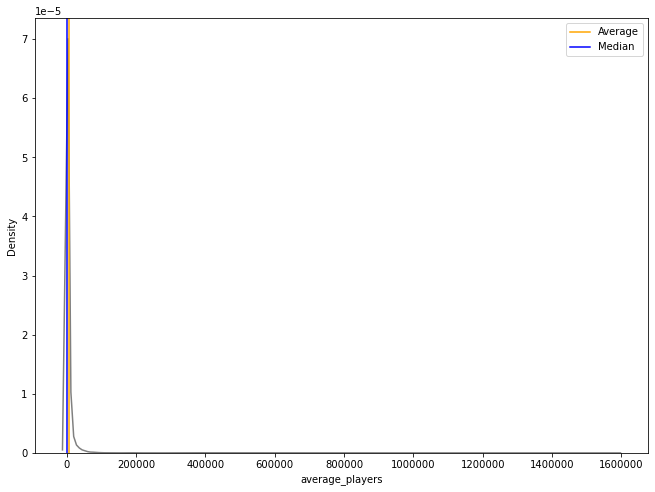

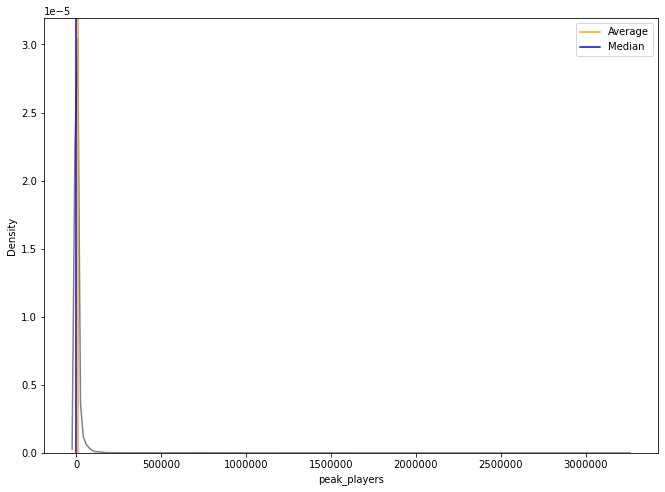

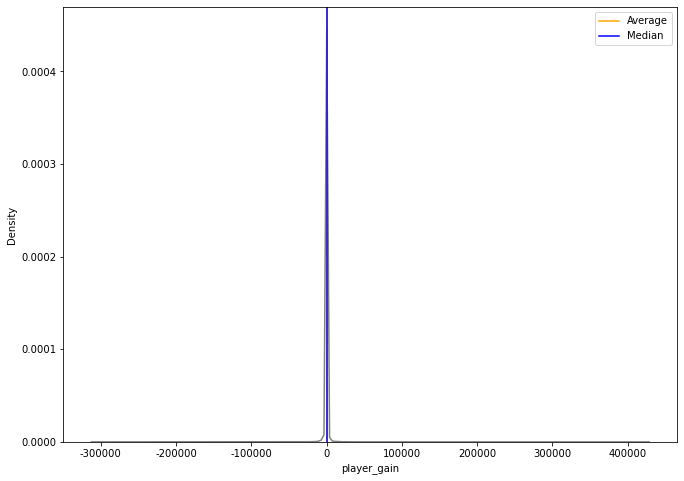

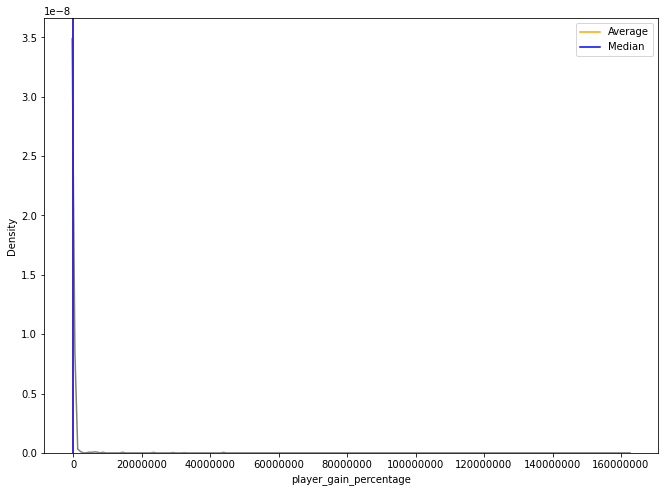

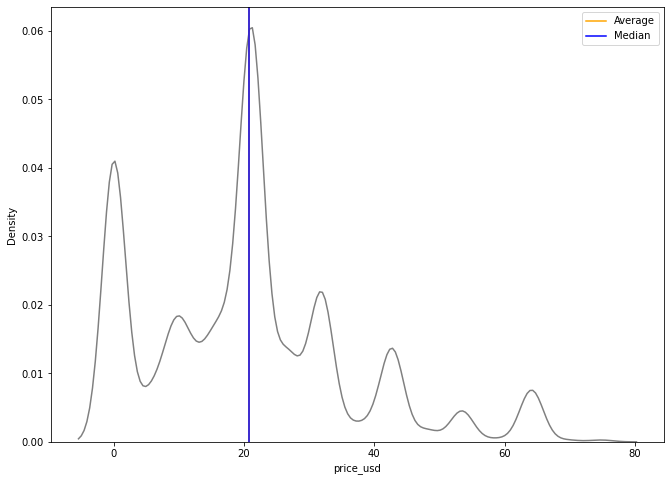

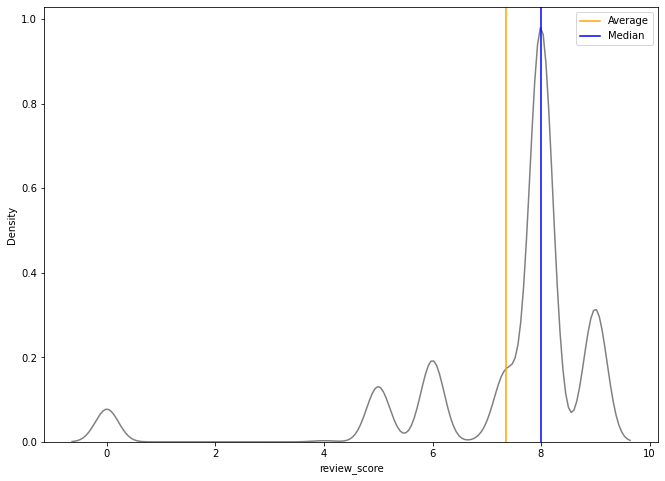

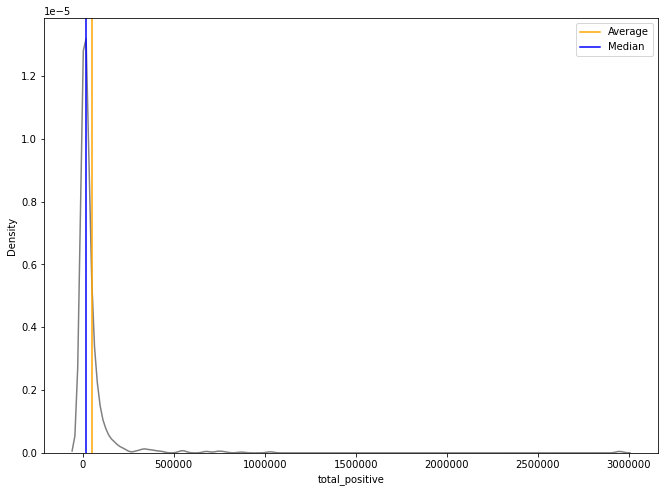

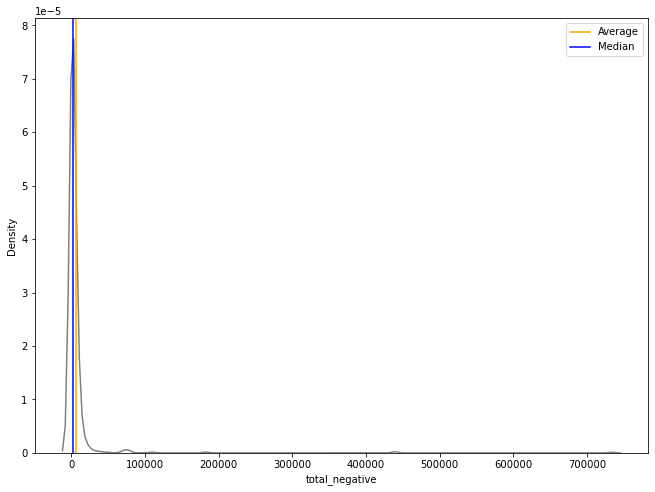

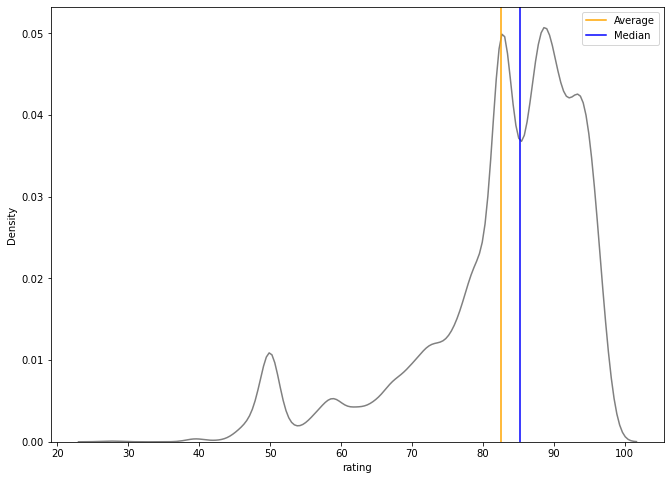

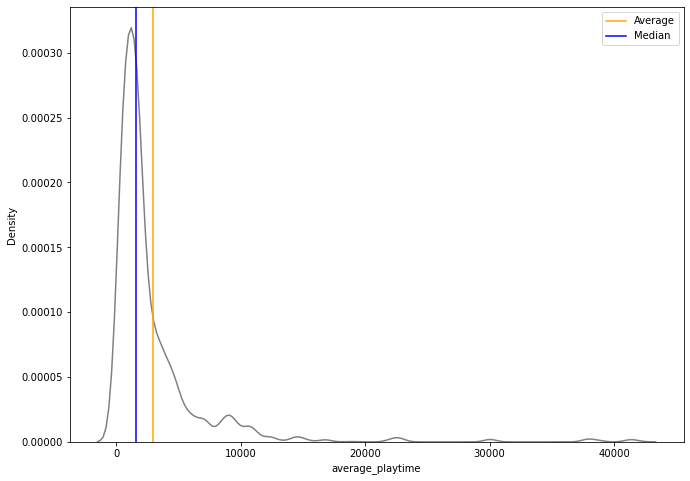

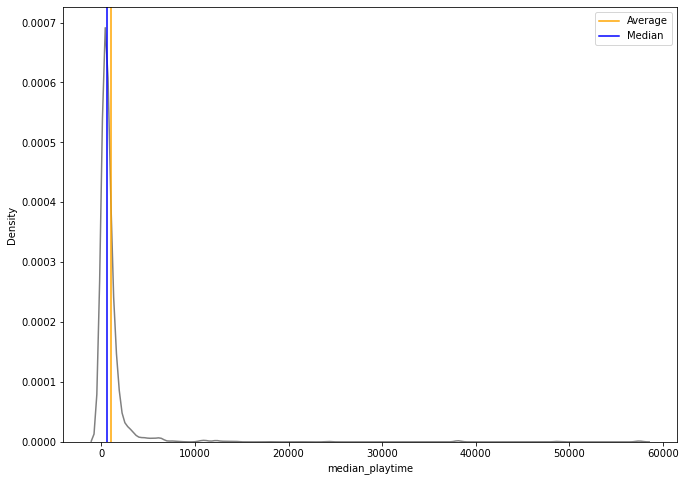

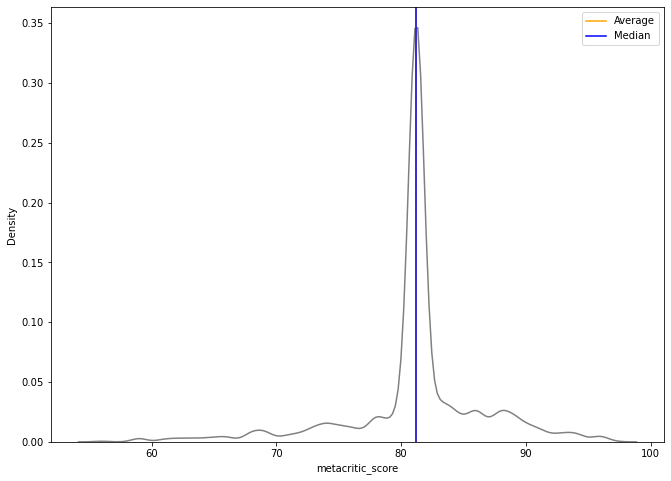

In [40]:
features = ['average_players', 'peak_players',
       'player_gain', 'player_gain_percentage','price_usd', 'review_score',
       'total_positive', 'total_negative', 'rating', 
       'average_playtime', 'median_playtime','metacritic_score',
       ]

for f in features:
       plt.figure(figsize = (11,8))
       sns.kdeplot(x=f, data = df, color = "grey")
       plt.axvline(df[f].mean(), label = "Average", color = "orange")
       plt.axvline(df[f].median(), label = "Median", color = "blue")
       plt.legend()
       

       plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))
       plt.show()

In [41]:
df_year_group = df.groupby("year",as_index=False).mean()

In [42]:
df_year_group

,year,average_players,peak_players,app_id,player_gain,player_gain_percentage,required_age,achievements,price_usd,review_score,total_positive,total_negative,rating,average_playtime,median_playtime,metacritic_score
0,2012,4383.08,8858.50,53736.88,-280.51,17831.20,2.17,67.50,15.08,8.02,84979.48,8160.32,87.26,3451.34,636.55,83.42
1,2013,4931.30,9921.61,98309.73,134.09,40268.90,2.98,72.80,16.35,7.95,75763.35,7120.29,86.60,3408.38,654.71,82.62
2,2014,6542.43,12832.57,137282.83,145.70,17179.32,2.99,76.35,17.34,7.90,68629.45,6607.77,86.21,3418.31,739.30,81.88
3,2015,7217.45,14074.36,182372.11,-122.39,7979.13,2.93,72.49,17.72,7.80,66079.00,6627.19,85.29,3424.63,860.18,81.60
4,2016,6443.37,12409.14,234413.20,-120.61,14210.74,2.88,67.13,19.07,7.71,62495.44,6559.09,84.26,3284.42,951.30,81.45
5,2017,6356.02,12363.54,293223.16,290.70,7728.10,2.70,65.13,19.89,7.55,56799.73,7423.48,83.32,3149.73,1059.78,81.21
6,2018,6456.55,12959.85,346670.06,-245.43,51306.14,2.55,64.54,20.28,7.38,51527.62,6976.74,82.52,3024.16,1044.88,81.13
7,2019,5122.59,9901.06,413159.51,-132.65,26751.49,2.41,63.71,20.84,7.29,47453.60,6389.18,82.15,2873.49,1055.53,80.98
8,2020,5612.52,10562.15,514330.34,-93.80,5525.42,2.32,61.60,21.90,7.23,43820.95,5844.17,81.96,2803.74,1165.88,81.01
9,2021,5268.61,10116.36,635979.74,-242.63,79.74,2.24,58.76,22.27,7.12,39996.98,5465.65,81.36,2635.86,1156.98,81.07


In [43]:
df = df.set_index("month")

In [44]:
df

,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,June
2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,May
2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,April
2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,March
2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,February
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,444.60,1019,625960,Stoneshard,-37.79,-7.83,Stoneshard is a challenging turn-based RPG set...,0.00,True,"['English', 'French', 'German', 'Italian', 'Ja...",['Ink Stains Games'],['HypeTrain Digital'],"['windows', 'linux']","['Single-player', 'Captions available', 'Remot...","['Adventure', 'Indie', 'RPG', 'Strategy', 'Ear...",54.00,2020-02-06,NaN,26.71,6.00,15281.00,4705.00,75.12,500000-1000000,1338.00,769.00,"['RPG', 'Strategy', 'Rogue-like', 'Open World ...",81.23,NaN,False,2020,Ju

In [45]:
df.columns

Index(['average_players', 'peak_players', 'app_id', 'game', 'player_gain',
       'player_gain_percentage', 'short_description', 'required_age', 'dlc',
       'supported_languages', 'developers', 'publishers', 'platforms',
       'categories', 'genres', 'achievements', 'release_date',
       'supported_audio', 'price_usd', 'review_score', 'total_positive',
       'total_negative', 'rating', 'total_owners_estimated',
       'average_playtime', 'median_playtime', 'tags', 'metacritic_score',
       'metacritic_url', 'is_recurring_subscription', 'year', 'month_name'],
      dtype='object')

In [46]:
data_resample = df.resample("M")

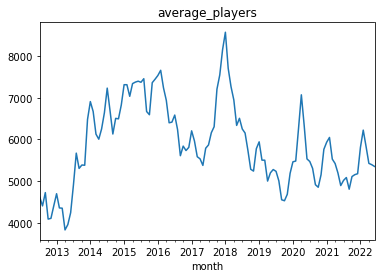

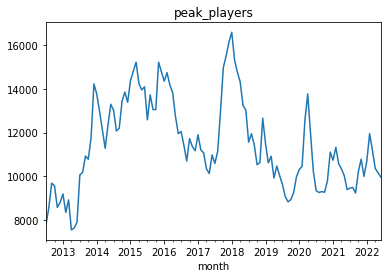

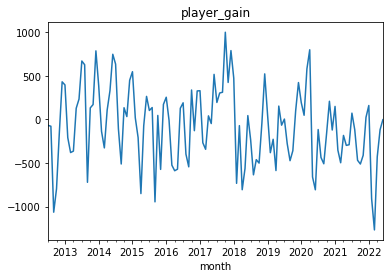

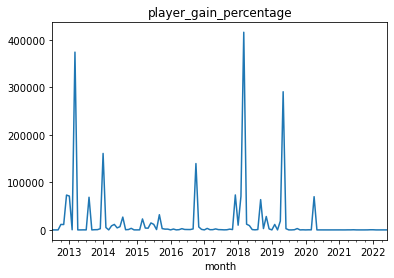

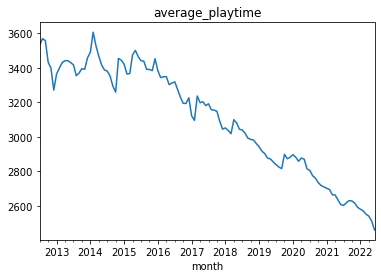

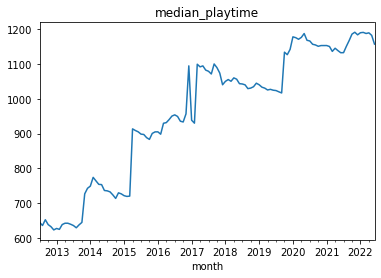

In [47]:
features = [
    'average_players', 
    'peak_players',
    'player_gain',
    'player_gain_percentage', 
    'average_playtime', 
    'median_playtime'
    ]

for f in features:
    data_resample[f].mean().plot()
    plt.title(f"{f}")
    plt.show()

<AxesSubplot:xlabel='month'>

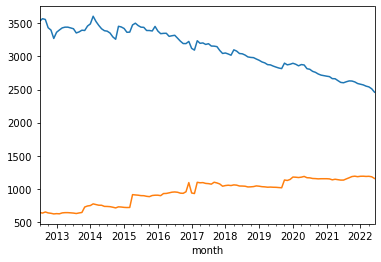

In [48]:
# Average playtime vs median playtime
# may be seeing less extreme playtime
# Playtime is increasing, since minimum value is greater, leading to higher median
data_resample["average_playtime"].mean().plot()
data_resample["median_playtime"].mean().plot()

<AxesSubplot:xlabel='month'>

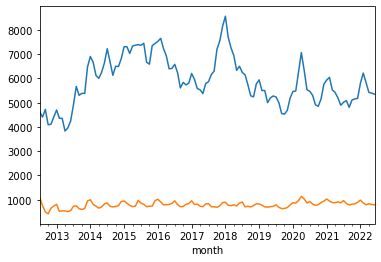

In [49]:
# Average vs. median 
# Median stays about the same
# Average fluctuates, looks seasonal
data_resample["average_players"].mean().plot()
data_resample["average_players"].median().plot()

<AxesSubplot:xlabel='month'>

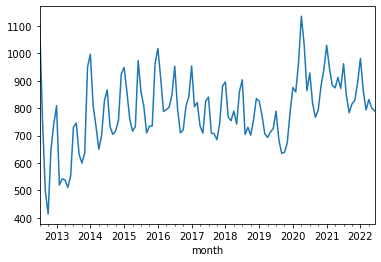

In [128]:
data_resample["average_players"].median().plot()

In [50]:
# Removes outliers in "player_gain" column for clearer picture

# Assign lower and upper quartiles with quantile() method
lower_quartile = df["player_gain"].quantile(0.25)
upper_quartile = df["player_gain"].quantile(0.75)

# IQR range is the calculation of the upper quartile - lower quartile
iqr = upper_quartile - lower_quartile

# Highest/lowest values that are not outliers 
# = upper or lower bound +- (IQR range x 1.5)
upper_bound = upper_quartile + (iqr * 1.5)
lower_bound = lower_quartile - (iqr * 1.5)


In [51]:
print("Upper bound:", upper_bound, " ", "Lower bound:", lower_bound)

Upper bound: 402.475   Lower bound: -455.305


In [52]:
# Filters out rows that less than the upper bound, and greater than the lower bound
non_outliers_gain = df[(df["player_gain"] < upper_bound) & (df["player_gain"] > lower_bound)]

In [53]:
non_outliers_gain["player_gain"].describe()

count   39847.00
mean      -14.92
std       145.94
min      -455.24
25%       -76.97
50%        -5.00
75%        48.20
max       402.46
Name: player_gain, dtype: float64

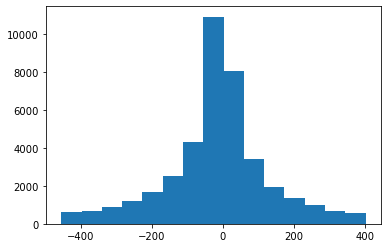

In [54]:
# Histogram of player_gain without outliers
# Range of -400 to 400
plt.hist(non_outliers_gain["player_gain"], bins = 15)
plt.show()

<AxesSubplot:xlabel='month'>

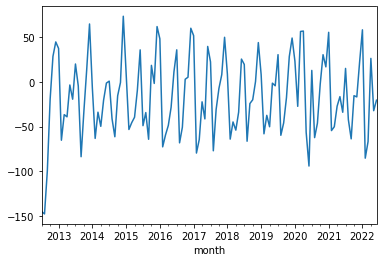

In [55]:
# Average player gain without outliers
non_outliers_gain.resample("M")["player_gain"].mean().plot()

In [56]:
df.groupby("month_name")[["average_players","player_gain"]].mean().iloc[[4, 3, 7, 0, 8, 6, 5, 1, 11, 10, 9, 2]]

,average_players,player_gain
month_name,,
January,6311.64,233.81
February,6249.28,-399.96
March,6048.96,-395.46
April,5933.88,-241.29
May,5716.92,-237.89
June,5628.06,-72.76
July,5723.49,56.11
August,5669.13,-199.96
September,5314.09,-451.73


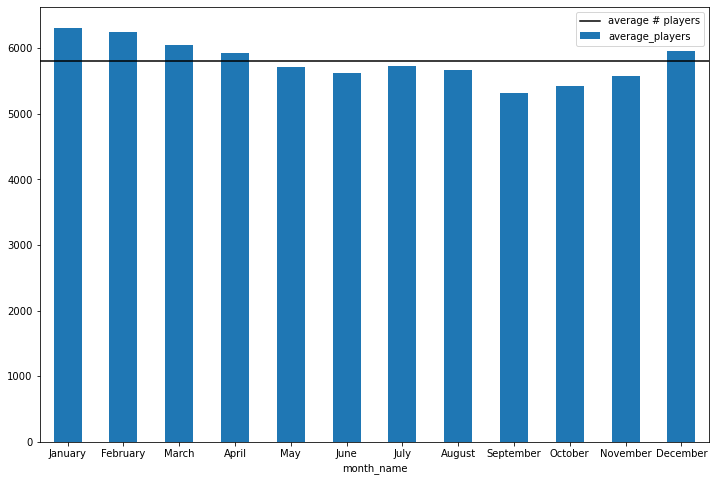

In [129]:
plt.figure(figsize = (12,8))
df.groupby("month_name")["average_players"].mean().iloc[[4, 3, 7, 0, 8, 6, 5, 1, 11, 10, 9, 2]].plot(kind = "bar")
plt.xticks(rotation=0)
plt.axhline(df["average_players"].mean(), color = "black", label = "average # players")
plt.legend()
plt.show()

<AxesSubplot:xlabel='month_name'>

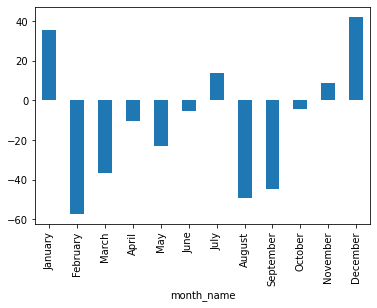

In [58]:
# Average player gain by month
df.groupby("month_name")["player_gain"].median().iloc[[4, 3, 7, 0, 8, 6, 5, 1, 11, 10, 9, 2]].plot(kind = "bar")

In [59]:
df["release_date"]

month
2022-06-30   2012-08-21
2022-05-31   2012-08-21
2022-04-30   2012-08-21
2022-03-31   2012-08-21
2022-02-28   2012-08-21
                ...    
2020-06-30   2020-02-06
2020-05-31   2020-02-06
2020-04-30   2020-02-06
2020-03-31   2020-02-06
2020-02-29   2020-02-06
Name: release_date, Length: 51942, dtype: datetime64[ns]

In [60]:
df.head()

,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,June
2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,May
2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,April
2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,March
2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,February


### Release date trends

In [61]:
# Assign two new columns based on release_date

# Extract the year 
df["release_year"] = df["release_date"].dt.year

# Extract the month
df["release_month"] = df["release_date"].dt.month

In [62]:
# Group the dataframe by the year of release
games_by_year = df.groupby("release_year")

<AxesSubplot:xlabel='release_year'>

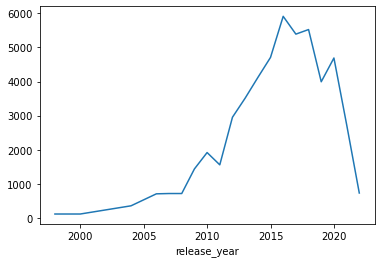

In [63]:
# Total games released per year, shows upward trend 
games_by_year.size().plot()

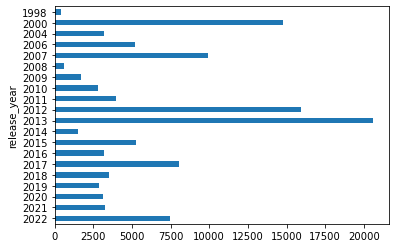

In [64]:
# Games released in a particular year, with associated average players 
# Example: games with a release year of 2013 have the greatest number of players, on average
games_by_year["average_players"].mean().plot(kind = "barh")
# Invert y axis, descending order
plt.gca().invert_yaxis()



In [65]:
games_by_year[["review_score","rating","metacritic_score"]].mean()

,review_score,rating,metacritic_score
release_year,,,
1998,9.00,94.86,96.00
2000,9.00,95.57,88.00
2004,8.67,92.92,83.00
2006,8.34,91.04,86.70
2007,8.50,92.65,88.17
2008,8.33,88.83,84.08
2009,8.11,88.04,85.04
2010,8.21,89.06,82.42
2011,7.91,86.04,81.78


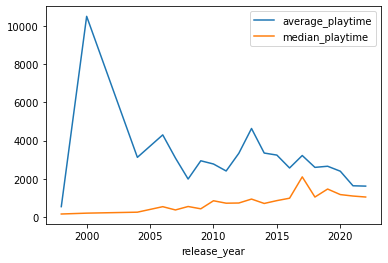

Median


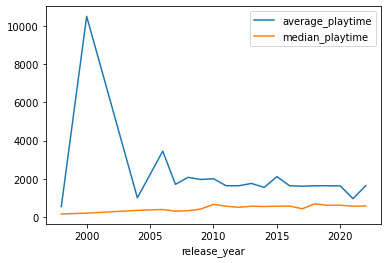

In [66]:
games_by_year[["average_playtime","median_playtime"]].mean().plot()
plt.show()
print("Median")
games_by_year[["average_playtime","median_playtime"]].median().plot()
plt.show()

In [67]:
games_by_month = df.groupby("release_month")

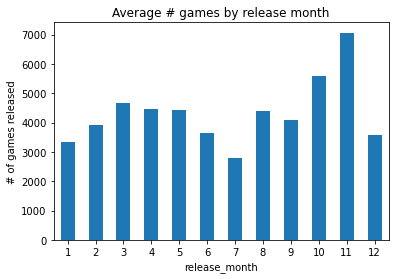

In [68]:
# Most games are released later in the year
games_by_month.size().plot.bar()
plt.xticks(rotation=0)
plt.ylabel("# of games released")
plt.title("Average # games by release month")
plt.show()

<AxesSubplot:xlabel='release_month'>

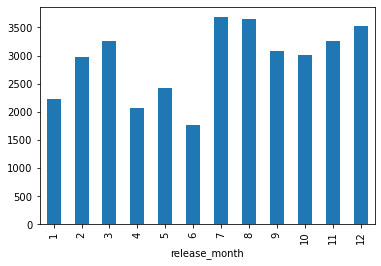

In [69]:
# Average playtime is generally greatest in the summer months and late winter
games_by_month["average_playtime"].mean().plot(kind = "bar")

<AxesSubplot:xlabel='release_month'>

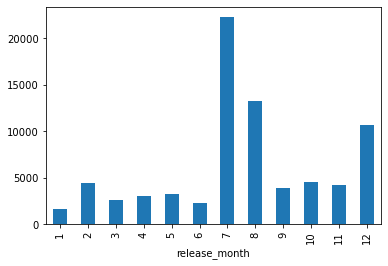

In [70]:
# July and August have the highest number of average players
games_by_month["average_players"].mean().plot(kind = "bar")

<AxesSubplot:xlabel='release_month'>

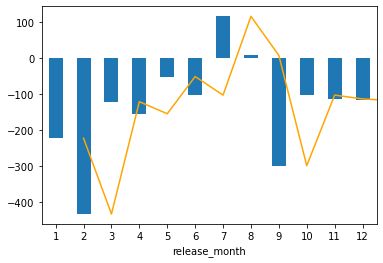

In [71]:
# Probably less relationship between when a game was released and player gain by month
games_by_month["player_gain"].mean().plot(kind = "bar")
games_by_month["player_gain"].mean().plot(color = "orange")

<AxesSubplot:xlabel='release_month'>

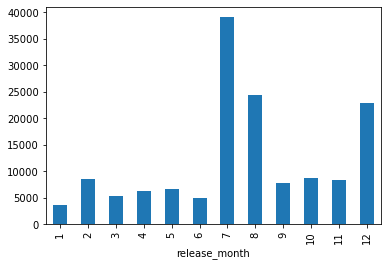

In [72]:
games_by_month["peak_players"].mean().plot(kind = "bar")

<AxesSubplot:xlabel='release_year'>

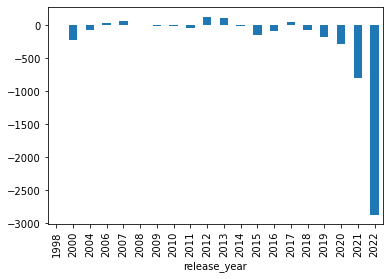

In [73]:
games_by_year["player_gain"].mean().plot(kind = "bar")

### Publishers/games

In [74]:
unique_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 51913
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      979 non-null    datetime64[ns]
 1   average_players            979 non-null    float64       
 2   peak_players               979 non-null    int64         
 3   app_id                     979 non-null    int64         
 4   game                       979 non-null    object        
 5   player_gain                979 non-null    float64       
 6   player_gain_percentage     979 non-null    float64       
 7   short_description          879 non-null    object        
 8   required_age               979 non-null    float64       
 9   dlc                        531 non-null    object        
 10  supported_languages        879 non-null    object        
 11  developers                 879 non-null    object        
 12  publis

In [75]:
unique_games["publishers"].value_counts()

['Electronic Arts']       30
['Ubisoft']               22
['Xbox Game Studios']     20
['Bethesda Softworks']    20
['Valve']                 16
                          ..
['Nolla Games']            1
['Miju Games']             1
['Team Wood Games']        1
['The Meta']               1
['HypeTrain Digital']      1
Name: publishers, Length: 524, dtype: int64

In [76]:
df.groupby("publishers")["average_players"].median().sort_values(ascending=False).head(10)

publishers
['KRAFTON, Inc.']                                     243053.03
['FromSoftware Inc.', 'BANDAI NAMCO Entertainment']   150758.02
['Stunlock Studios']                                   82208.54
['Bungie ']                                            65955.10
['Wemade']                                             55475.16
['NetEase Games Montréal']                             54299.83
['Studio Wildcard']                                    41884.03
['Digital Extremes']                                   35514.00
['Facepunch Studios']                                  32438.98
['Amazon Games']                                       32387.84
Name: average_players, dtype: float64

<AxesSubplot:ylabel='game'>

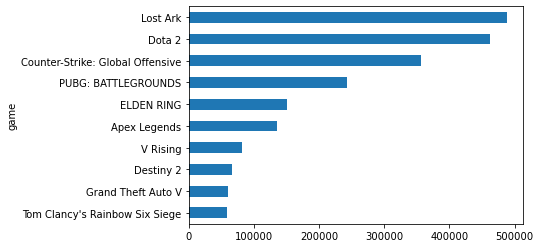

In [77]:
df.groupby("game")["average_players"].median().sort_values().tail(10).plot(kind = "barh")

<AxesSubplot:ylabel='game'>

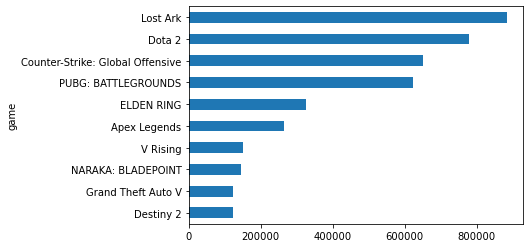

In [78]:
df.groupby("game")["peak_players"].median().sort_values().tail(10).plot(kind = "barh")

In [79]:
import warnings

warnings.filterwarnings("ignore")

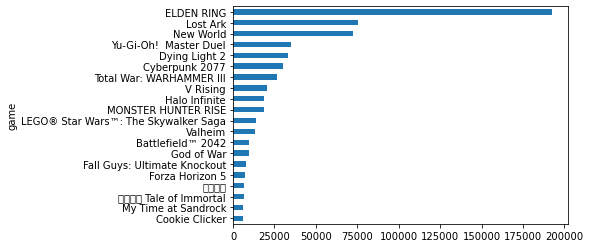

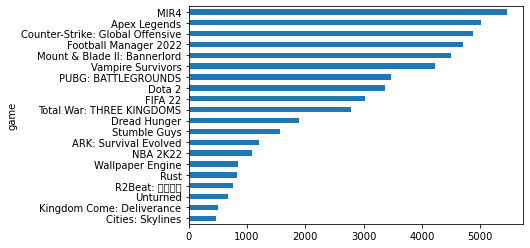

In [80]:
# Games with the greatest player loss, on average 
# abs function converts negative to positive for clearer plotting
abs(df.groupby("game")["player_gain"].mean().sort_values().head(20)).plot(kind = "barh")
# Invert y axis, descending order
plt.gca().invert_yaxis()
plt.show()

# Games with positive player growth, on average 
df.groupby("game")["player_gain"].mean().sort_values(ascending = False).head(20).plot(kind = "barh")
plt.gca().invert_yaxis()
plt.show()


In [81]:
df["age"] = 2022 - df["release_year"]

In [82]:
df["age"].describe()

count   51942.00
mean        6.52
std         3.91
min         0.00
25%         4.00
50%         6.00
75%         9.00
max        24.00
Name: age, dtype: float64

In [83]:
df

,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name,release_year,release_month,age
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,June,2012,8,10
2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,May,2012,8,10
2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,April,2012,8,10
2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,March,2012,8,10
2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,February,2012,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,444.60,1019,625960,Stoneshard,-37.79,-7.83,Stoneshard is a challenging turn-based RPG set...,0.00,True,"['English', 'French', 'German', 'Italian', 'Ja...",['Ink Stains Games'],['HypeTrain Digital'],"['windows', 'linux']","['Single-player', 'Captions available', 'Remot...","['Adventure', 'Indie', 'RPG', 'Strategy', 'Ear...",54.00,2020-02-06,NaN,26.71,6.00,15281.00,4705.00,75.12,500000-10

### Steam player trends insights
- data is seasonal
- average number of players increases over the years
- game reviews/ratings match closely
- single player and multiplayer tags are most common
- most games are released in november and december
- average playtime is highest in late winter/early spring, dips down below average in summer time
- spike in 2018
- ELDEN RING, Lost Ark, and New World have the greatest player loss (on average)
- MIR4, Apex Legends, and Counter-Strike: Global Offensive have the highest average player growth

In [84]:
df = df.reset_index()

In [86]:
# Globabl stats for twitch viewership, does not include game titles
twitch_global = pd.read_csv(r"data_files\Twitch_global_data.csv")

# Individual game stats
twitch_game = pd.read_csv(r"data_files\Twitch_game_data.csv",encoding = "ISO-8859-1")

In [87]:
twitch_global

,year,Month,Hours_watched,Avg_viewers,Peak_viewers,Streams,Avg_channels,Games_streamed
0,2016,1,480241904,646355,1275257,7701675,20076,"12,149"
1,2016,2,441859897,635769,1308032,7038520,20427,"12,134"
2,2016,3,490669308,660389,1591551,7390957,20271,"12,234"
3,2016,4,377975447,525696,1775120,6869719,16791,"12,282"
4,2016,5,449836631,605432,1438962,7535519,19394,"12,424"
...,...,...,...,...,...,...,...,...
67,2021,8,1974586275,2657585,4778502,20767741,100701,"36,471"
68,2021,9,1857514531,2583469,5599210,18826493,95513,"35,861"
69,2021,10,2020197953,2718974,6086487,18209793,91858,"36,406"
70,2021,11,1812117484,2520330,5941684,17415525,90774,"35,043"


In [88]:
twitch_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            72 non-null     int64 
 1   Month           72 non-null     int64 
 2   Hours_watched   72 non-null     int64 
 3   Avg_viewers     72 non-null     int64 
 4   Peak_viewers    72 non-null     int64 
 5   Streams         72 non-null     int64 
 6   Avg_channels    72 non-null     int64 
 7   Games_streamed  72 non-null     object
dtypes: int64(7), object(1)
memory usage: 4.6+ KB


In [89]:
twitch_global.describe()

,year,Month,Hours_watched,Avg_viewers,Peak_viewers,Streams,Avg_channels
count,72.00,72.00,72.00,72.00,72.00,72.00,72.00
mean,2018.50,6.50,1042294502.22,1426985.96,3003735.96,13934321.11,54572.43
std,1.72,3.48,586050234.60,799579.66,1582052.31,5539751.88,33246.32
min,2016.00,1.00,362833210.00,504635.00,1186009.00,5507554.00,16592.00
25%,2017.00,3.75,534936067.25,746080.75,1750812.75,8282278.25,24588.00
50%,2018.50,6.50,871857012.00,1195169.50,2473509.00,14460996.00,45559.50
75%,2020.00,9.25,1622832490.50,2220380.75,4084978.75,17905686.00,91888.00
max,2021.00,12.00,2308295297.00,3106723.00,6516666.00,25614207.00,122763.00


In [90]:
twitch_global.columns

Index(['year', 'Month', 'Hours_watched', 'Avg_viewers', 'Peak_viewers',
       'Streams', 'Avg_channels', 'Games_streamed'],
      dtype='object')

1,042,294,502.22

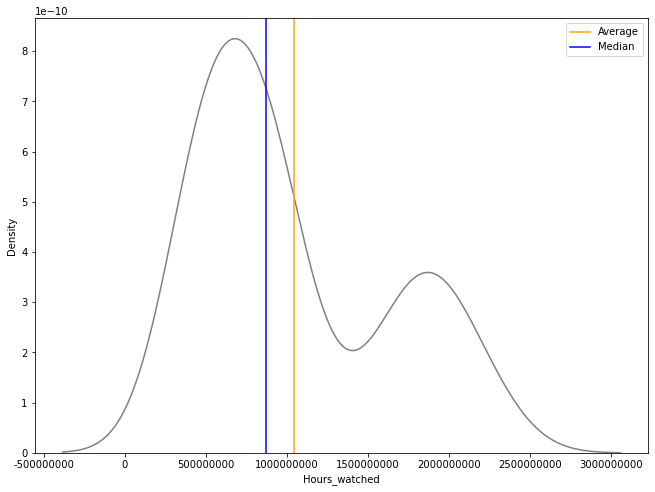

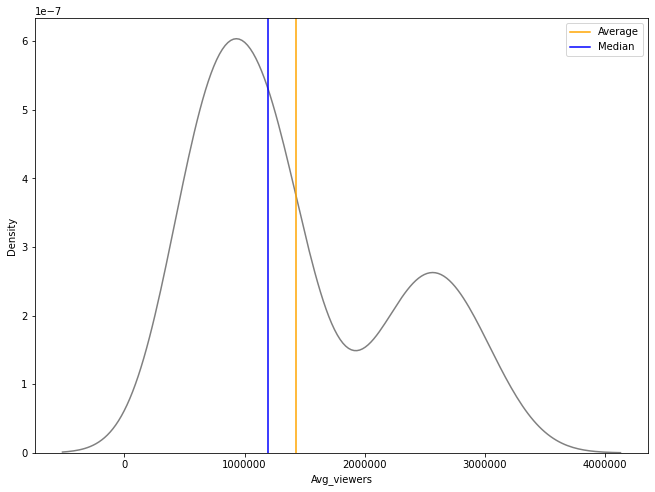

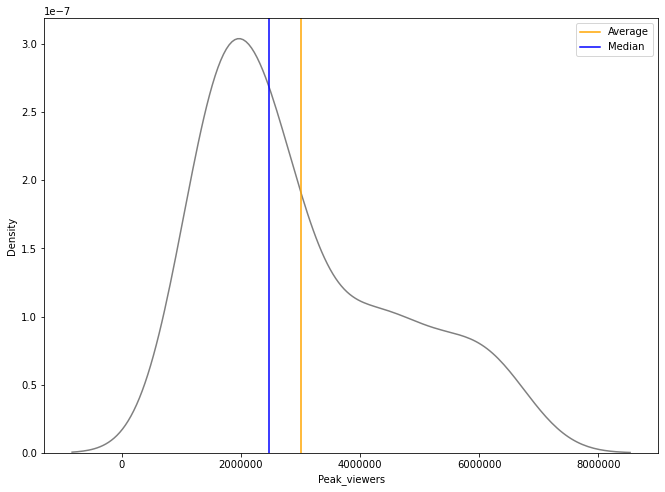

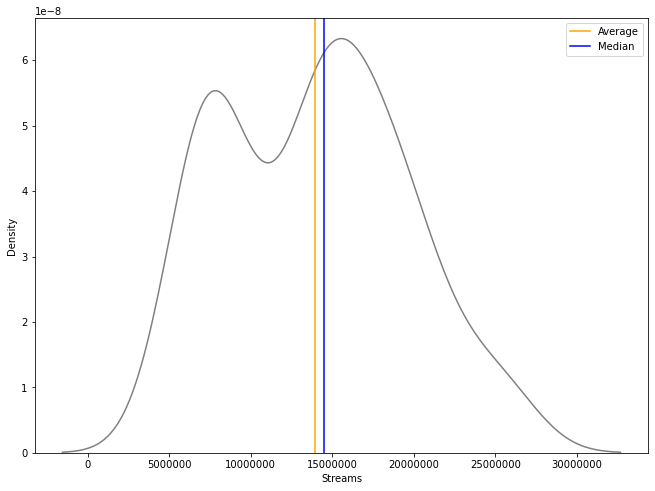

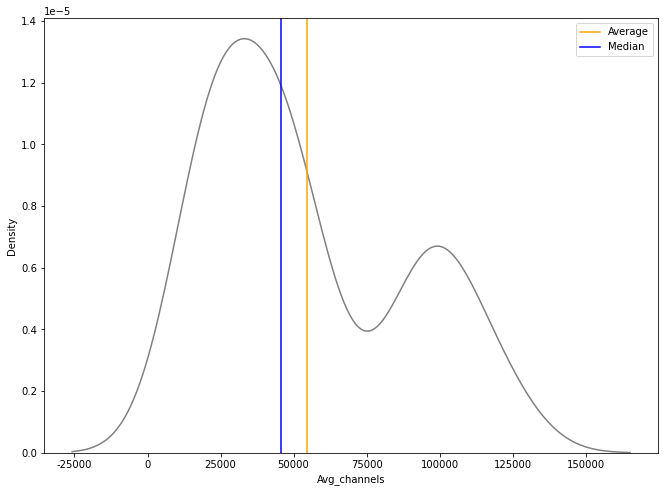

In [91]:
features = ['Hours_watched', 'Avg_viewers', 'Peak_viewers',
       'Streams', 'Avg_channels']

for f in features:
       plt.figure(figsize = (11,8))
       sns.kdeplot(x=f, data = twitch_global, color = "grey")
       plt.axvline(twitch_global[f].mean(), label = "Average", color = "orange")
       plt.axvline(twitch_global[f].median(), label = "Median", color = "blue")
       plt.legend()
       

       plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))
       plt.show()

In [92]:
year_group = twitch_global.groupby("year",as_index=False).mean()
year_group.columns

Index(['year', 'Month', 'Hours_watched', 'Avg_viewers', 'Peak_viewers',
       'Streams', 'Avg_channels'],
      dtype='object')

In [93]:
year_group

,year,Month,Hours_watched,Avg_viewers,Peak_viewers,Streams,Avg_channels
0,2016,6.50,439291907.67,600791.25,1455340.75,7058533.42,19127.92
1,2017,6.50,544465174.67,746867.92,1716168.08,7890737.25,24623.08
2,2018,6.50,780777549.58,1070230.75,2332288.00,13968452.67,41131.42
3,2019,6.50,916683897.75,1257788.92,2742726.75,14813621.42,49522.83
4,2020,6.50,1550581166.50,2119968.00,4090603.75,18348952.33,87628.08
5,2021,6.50,2021967317.17,2766268.92,5685288.42,21525629.58,105401.25


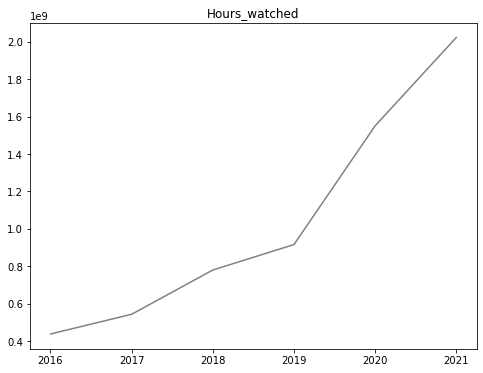

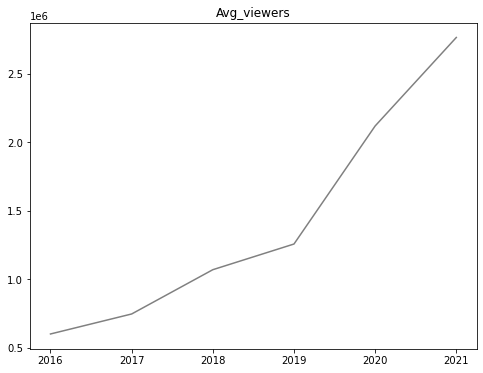

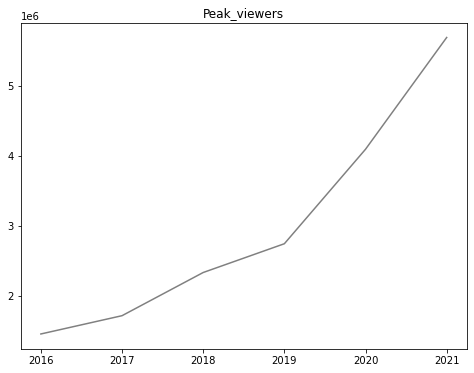

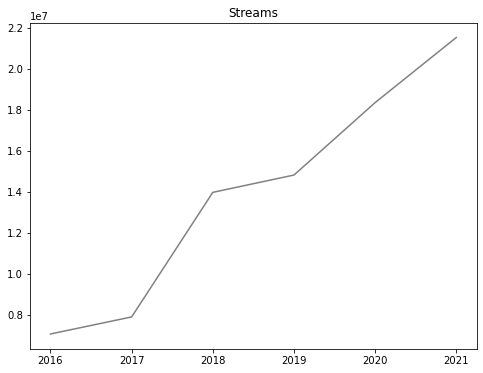

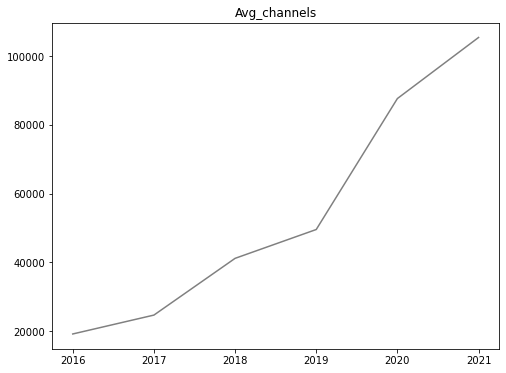

In [94]:
features = ['Hours_watched', 'Avg_viewers', 'Peak_viewers', 'Streams',
       'Avg_channels']

for f in features:
       plt.figure(figsize = (8,6))
       plt.plot(year_group["year"], year_group[f], color = "grey")
       plt.title(f"{f}")
       plt.show()
    

In [95]:
twitch_global["Games_streamed"] = twitch_global["Games_streamed"].str.replace(",","").astype(int)

In [96]:
# mean and median relatively close
twitch_global["Games_streamed"].describe()

count      72.00
mean    21615.32
std      7768.37
min     12134.00
25%     15701.25
50%     19431.50
75%     25418.25
max     36960.00
Name: Games_streamed, dtype: float64

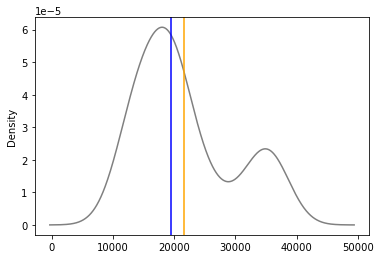

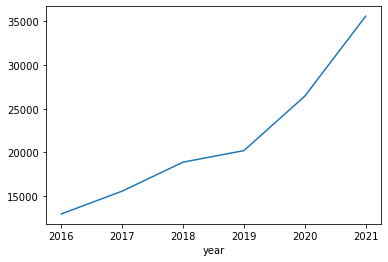

In [97]:
twitch_global["Games_streamed"].plot.kde(color = "grey")
plt.axvline(twitch_global["Games_streamed"].mean(), color = "orange")
plt.axvline(twitch_global["Games_streamed"].median(), color = "blue")

plt.show()
twitch_global.groupby("year")["Games_streamed"].mean().plot()
plt.show()

In [98]:
twitch_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   year            72 non-null     int64
 1   Month           72 non-null     int64
 2   Hours_watched   72 non-null     int64
 3   Avg_viewers     72 non-null     int64
 4   Peak_viewers    72 non-null     int64
 5   Streams         72 non-null     int64
 6   Avg_channels    72 non-null     int64
 7   Games_streamed  72 non-null     int32
dtypes: int32(1), int64(7)
memory usage: 4.3 KB


In [99]:
twitch_global["year"] = pd.to_datetime(twitch_global["year"],format='%Y')

In [100]:
twitch_global["year"] = twitch_global["year"].dt.year

In [101]:
cols=["year","Month"]
twitch_global["date"] = twitch_global[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")


In [102]:
twitch_global["date"] = pd.to_datetime(twitch_global["date"]) + pd.offsets.MonthEnd() # <-- offset to month end instead of beginning of month

In [103]:
twitch_global.columns

Index(['year', 'Month', 'Hours_watched', 'Avg_viewers', 'Peak_viewers',
       'Streams', 'Avg_channels', 'Games_streamed', 'date'],
      dtype='object')

In [104]:
twitch_global = twitch_global[['date','Hours_watched', 'Avg_viewers', 'Peak_viewers',
       'Streams', 'Avg_channels', 'Games_streamed']]

In [105]:
twitch_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            72 non-null     datetime64[ns]
 1   Hours_watched   72 non-null     int64         
 2   Avg_viewers     72 non-null     int64         
 3   Peak_viewers    72 non-null     int64         
 4   Streams         72 non-null     int64         
 5   Avg_channels    72 non-null     int64         
 6   Games_streamed  72 non-null     int32         
dtypes: datetime64[ns](1), int32(1), int64(5)
memory usage: 3.8 KB


### Twitch (global insights)
- Every variable from the global insights data shows an increasing trend over the years
- Hours watched and average # viewers increases, shows that twitch "popularity" is gaining

In [106]:
twitch_game

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044 hours,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105 hours,372654,2197,120849,64378,1117,57.62
2,3,Dota 2,1,2016,45185893,433397 hours,315083,1100,44074,60815,583,104.26
3,4,Hearthstone,1,2016,39936159,235903 hours,131357,517,36170,53749,317,169.29
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578 hours,71639,3620,214054,21740,1549,14.03
...,...,...,...,...,...,...,...,...,...,...,...,...
14395,196,Garry's Mod,12,2021,630902,21753 hours,24951,99,3537,849,29,29.00
14396,197,Call of Duty: Black Ops Cold War,12,2021,622497,223641 hours,26559,654,25366,837,300,2.78
14397,198,Noita,12,2021,620983,13935 hours,27826,41,1961,835,18,44.56
14398,199,Pro Soccer Online,12,2021,619859,606 hours,36182,20,84,834,0,1022.87


In [107]:
# 1 missing value in Game column
twitch_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              14400 non-null  int64  
 1   Game              14399 non-null  object 
 2   Month             14400 non-null  int64  
 3   Year              14400 non-null  int64  
 4   Hours_watched     14400 non-null  int64  
 5   Hours_Streamed    14400 non-null  object 
 6   Peak_viewers      14400 non-null  int64  
 7   Peak_channels     14400 non-null  int64  
 8   Streamers         14400 non-null  int64  
 9   Avg_viewers       14400 non-null  int64  
 10  Avg_channels      14400 non-null  int64  
 11  Avg_viewer_ratio  14400 non-null  float64
dtypes: float64(1), int64(9), object(2)
memory usage: 1.3+ MB


In [108]:
twitch_game[twitch_game["Game"].isna()]

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
7561,162,NaN,2,2019,317951,77004 hours,30919,5804,21758,473,114,4.13


In [109]:
twitch_game["Rank"].nunique()

200

In [110]:
# game rank applies to different games, so it will be difficult to determine name
twitch_game[twitch_game["Rank"] == 162]

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
161,162,Tony Hawk's Pro Skater,1,2016,211450,159 hours,111383,10,37,284,0,1329.87
361,162,Microsoft Flight Simulator X,2,2016,131330,12949 hours,2390,54,1018,188,18,10.14
561,162,Plants vs Zombies: Garden Warfare 2,3,2016,145582,9430 hours,2642,47,3679,195,12,15.44
761,162,Star Citizen,4,2016,133619,6413 hours,1848,23,858,185,8,20.84
961,162,Roblox,5,2016,125130,27174 hours,6795,111,8952,168,36,4.60
...,...,...,...,...,...,...,...,...,...,...,...,...
13561,162,Call of Duty: Vanguard,8,2021,950749,20981 hours,136234,2155,7382,1279,28,45.31
13761,162,Summoners War: Sky Arena,9,2021,904985,17528 hours,29140,59,1072,1258,24,51.63
13961,162,Don't Starve Together,10,2021,822210,34080 hours,8429,108,4616,1106,45,24.13
14161,162,Yu-Gi-Oh! Duel Links,11,2021,917353,23292 hours,9046,71,2232,1275,32,39.38


In [111]:
# Drop the missing row
twitch_game = twitch_game.dropna()

In [112]:
twitch_game["Hours_Streamed"] = twitch_game["Hours_Streamed"].str.replace("hours","").astype(int)

In [113]:
twitch_game.columns


Index(['Rank', 'Game', 'Month', 'Year', 'Hours_watched', 'Hours_Streamed',
       'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers',
       'Avg_channels', 'Avg_viewer_ratio'],
      dtype='object')

In [114]:
twitch_game[
    [
        'Hours_watched',
        'Hours_Streamed',
        'Peak_viewers', 
        'Peak_channels', 
        'Streamers', 
        'Avg_viewers',
        'Avg_channels', 
        'Avg_viewer_ratio'
        ]
        ].describe()

,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
count,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00
mean,4782757.99,157125.30,55096.80,586.40,17224.46,6554.21,214.87,81.88
std,16679490.00,542829.50,132917.88,2721.16,54533.41,22859.34,743.88,368.89
min,89811.00,19.00,441.00,1.00,0.00,120.00,0.00,1.95
25%,368179.00,12212.00,8351.00,51.50,1479.00,504.00,16.00,16.12
50%,819895.00,31630.00,20169.00,122.00,4126.00,1125.00,43.00,29.16
75%,2295441.00,88728.00,45986.00,318.00,10712.00,3159.00,121.00,57.80
max,344551979.00,10245704.00,3123208.00,129860.00,1013029.00,479209.00,13789.00,13601.87


Some games look like they're driving up the averages in the summary stats.

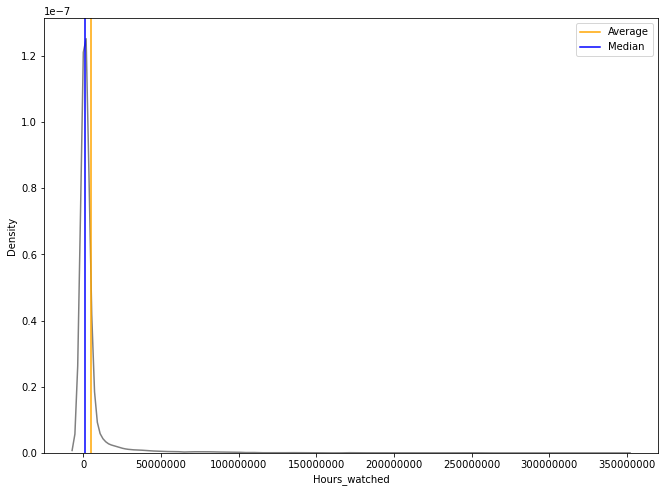

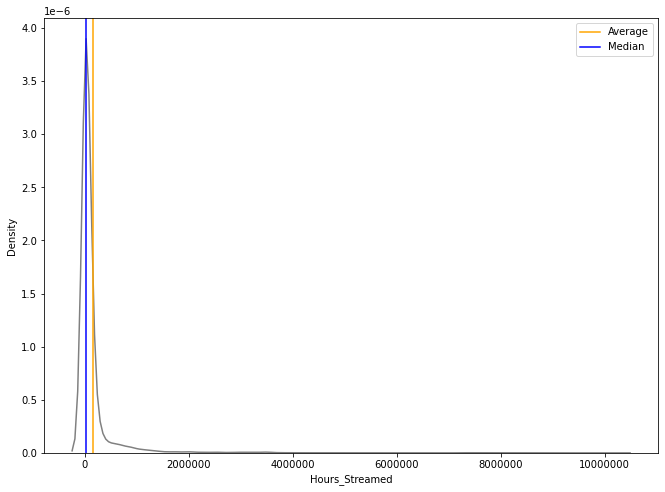

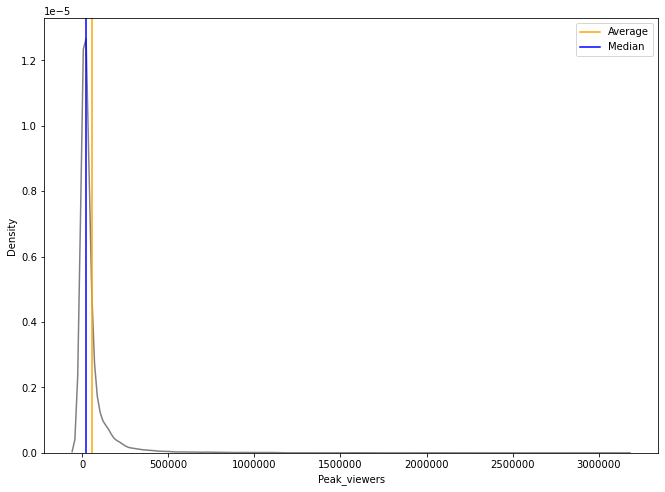

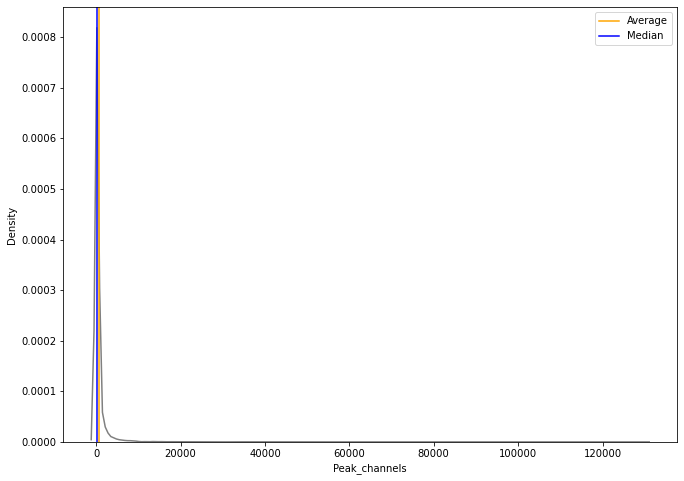

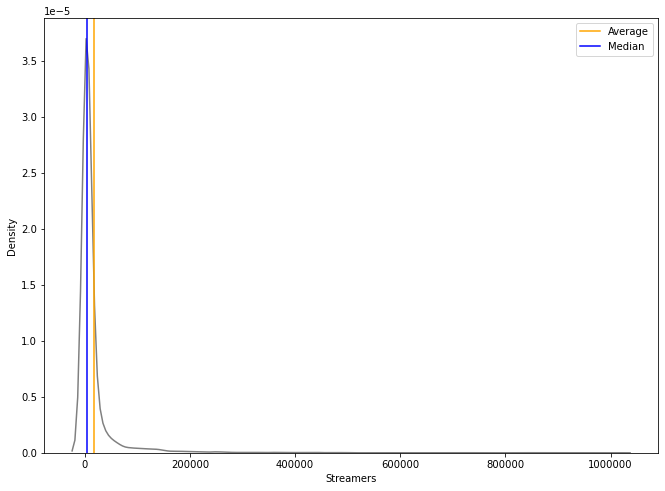

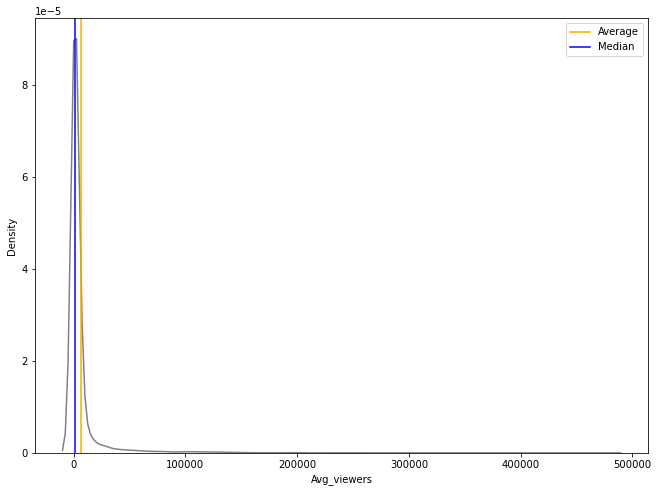

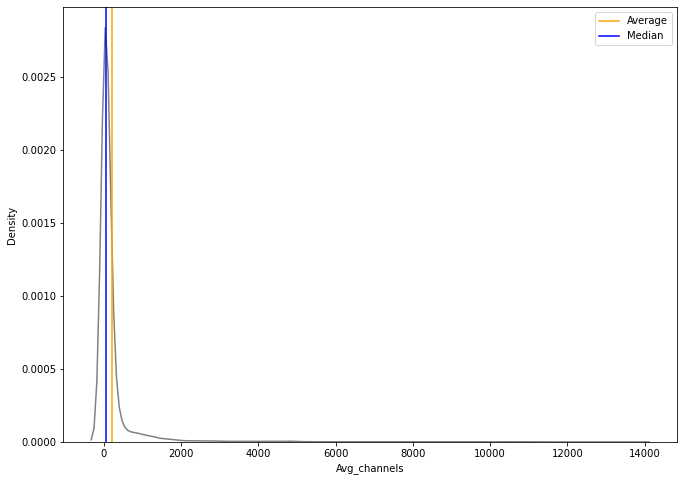

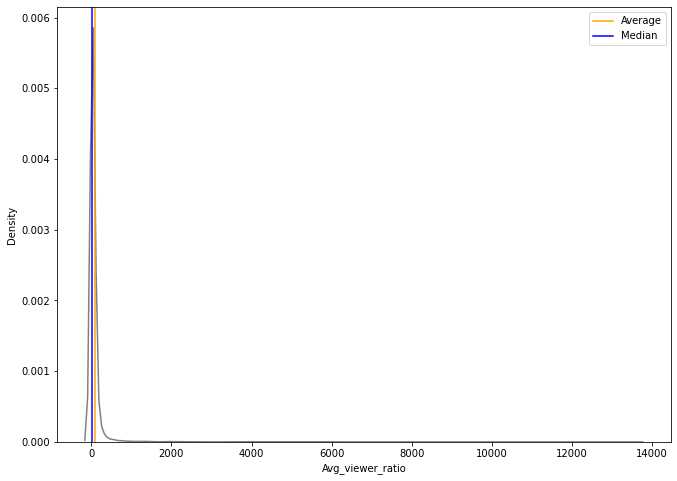

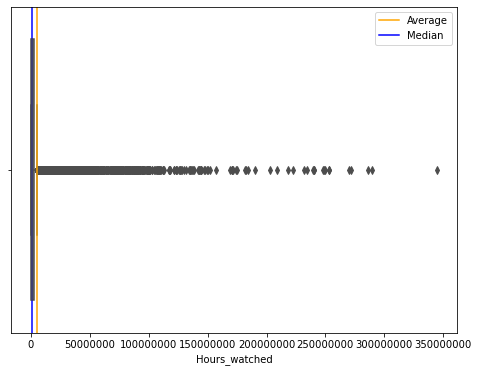

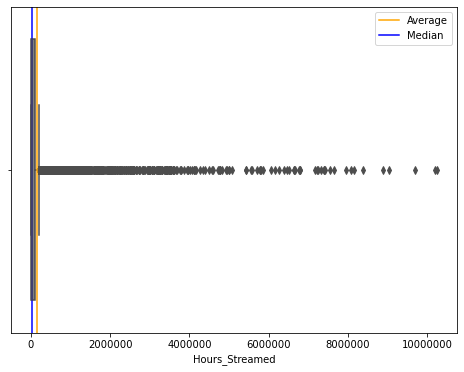

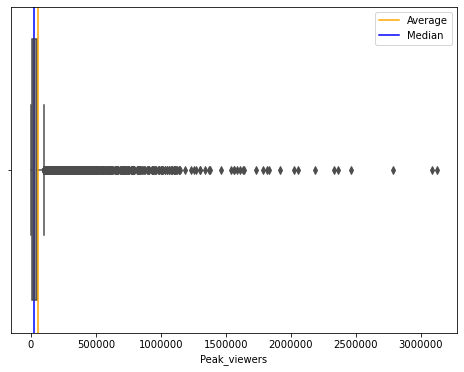

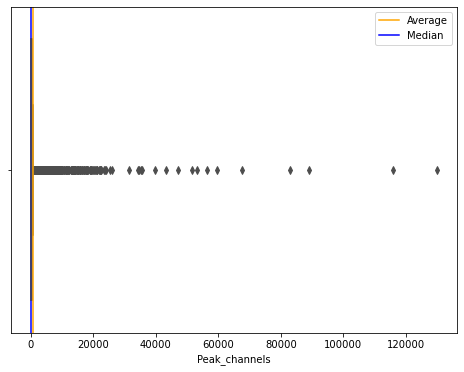

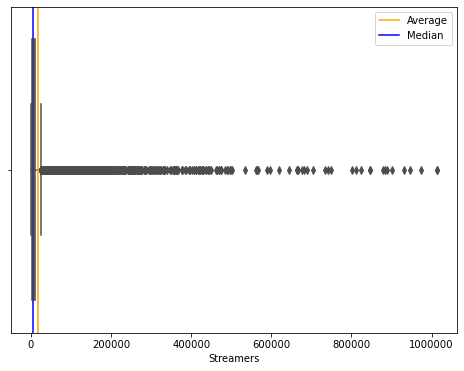

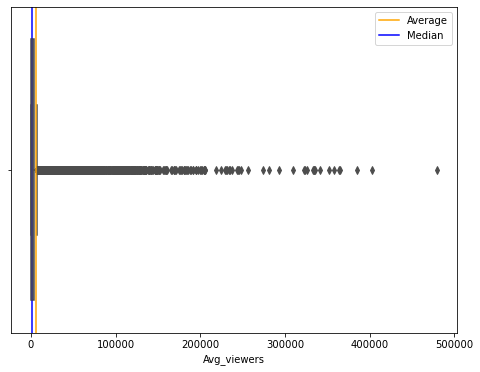

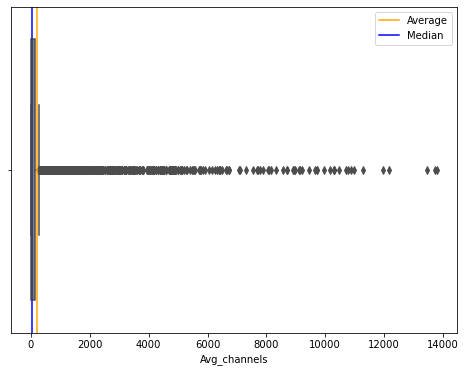

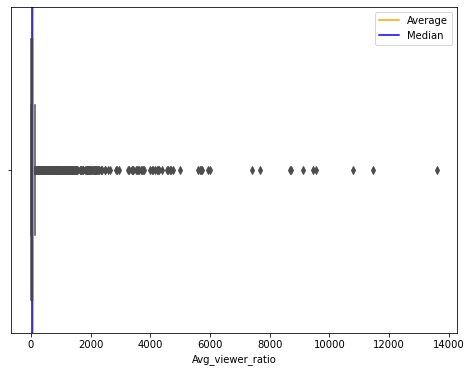

In [115]:
features = [
        'Hours_watched',
        'Hours_Streamed',
        'Peak_viewers', 
        'Peak_channels', 
        'Streamers', 
        'Avg_viewers',
        'Avg_channels', 
        'Avg_viewer_ratio'
        ]

for f in features:
       plt.figure(figsize = (11,8))
       sns.kdeplot(x=f, data = twitch_game, color = "grey")
       plt.axvline(twitch_game[f].mean(), label = "Average", color = "orange")
       plt.axvline(twitch_game[f].median(), label = "Median", color = "blue")
       plt.legend()
       

       plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))
       plt.show()

for f in features:
       plt.figure(figsize = (8,6))
       sns.boxplot(x=f, data = twitch_game, color = "grey")
       plt.axvline(twitch_game[f].mean(), label = "Average", color = "orange")
       plt.axvline(twitch_game[f].median(), label = "Median", color = "blue")
       plt.legend()
       

       plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))
       plt.show()


In [116]:
twitch_game

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169.29
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03
...,...,...,...,...,...,...,...,...,...,...,...,...
14395,196,Garry's Mod,12,2021,630902,21753,24951,99,3537,849,29,29.00
14396,197,Call of Duty: Black Ops Cold War,12,2021,622497,223641,26559,654,25366,837,300,2.78
14397,198,Noita,12,2021,620983,13935,27826,41,1961,835,18,44.56
14398,199,Pro Soccer Online,12,2021,619859,606,36182,20,84,834,0,1022.87


In [117]:
pd.to_datetime(twitch_game["Year"],format='%Y')

0       2016-01-01
1       2016-01-01
2       2016-01-01
3       2016-01-01
4       2016-01-01
           ...    
14395   2021-01-01
14396   2021-01-01
14397   2021-01-01
14398   2021-01-01
14399   2021-01-01
Name: Year, Length: 14399, dtype: datetime64[ns]

In [118]:

cols=["Year","Month"]
twitch_game["date"] = twitch_game[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [119]:
twitch_game["date"] = pd.to_datetime(twitch_game["date"]) + pd.offsets.MonthEnd()

In [120]:
twitch_game

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,date
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29,2016-01-31
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,2016-01-31
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26,2016-01-31
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169.29,2016-01-31
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03,2016-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14395,196,Garry's Mod,12,2021,630902,21753,24951,99,3537,849,29,29.00,2021-12-31
14396,197,Call of Duty: Black Ops Cold War,12,2021,622497,223641,26559,654,25366,837,300,2.78,2021-12-31
14397,198,Noita,12,2021,620983,13935,27826,41,1961,835,18,44.56,2021-12-31
14398,199,Pro Soccer Online,12,2021,619859,606,36182,20,84,834,0,1022.87,2021-12-31


In [121]:
twitch_game.columns

Index(['Rank', 'Game', 'Month', 'Year', 'Hours_watched', 'Hours_Streamed',
       'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers',
       'Avg_channels', 'Avg_viewer_ratio', 'date'],
      dtype='object')

In [124]:
twitch_game = twitch_game[
    [
        'Game',
        'Rank',
        'date', 
        'Hours_watched', 
        'Hours_Streamed',
        'Peak_viewers', 
        'Peak_channels', 
        'Streamers', 
        'Avg_viewers',
        'Avg_channels', 
        'Avg_viewer_ratio'
        ]
        ]

In [125]:
twitch_game

,Game,Rank,date,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,League of Legends,1,2016-01-31,94377226,1362044,530270,2903,129172,127021,1833,69.29
1,Counter-Strike: Global Offensive,2,2016-01-31,47832863,830105,372654,2197,120849,64378,1117,57.62
2,Dota 2,3,2016-01-31,45185893,433397,315083,1100,44074,60815,583,104.26
3,Hearthstone,4,2016-01-31,39936159,235903,131357,517,36170,53749,317,169.29
4,Call of Duty: Black Ops III,5,2016-01-31,16153057,1151578,71639,3620,214054,21740,1549,14.03
...,...,...,...,...,...,...,...,...,...,...,...
14395,Garry's Mod,196,2021-12-31,630902,21753,24951,99,3537,849,29,29.00
14396,Call of Duty: Black Ops Cold War,197,2021-12-31,622497,223641,26559,654,25366,837,300,2.78
14397,Noita,198,2021-12-31,620983,13935,27826,41,1961,835,18,44.56
14398,Pro Soccer Online,199,2021-12-31,619859,606,36182,20,84,834,0,1022.87


### New csv files

After performing any remaining data cleaning the new dataframes can be saved back to a new csv file for analysis later.

The cell below should only be performed once.

In [127]:
#twitch_global.to_csv("twitch_global_data_clean.csv", index=False)
#twitch_game.to_csv("twitch_game_data_clean.csv", index=False)
#df.to_csv("steam_charts_final_clean.csv",index=False)